In [ ]:
!pip install -q -U keras-tuner
# !pip uninstall yfinance
# !pip install yfinance==0.2.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.2 MB/s eta 0:00:00


# Load Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
import keras
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,GRU,LSTM
from keras.layers import Dropout

# Extract Data and Visualising + Data Processing

In [ ]:
LOSS = 'mean_squared_error'
METRICS = ['mae']

In [ ]:
yf.pdr_override()
#Load data
company = 'GOOG'

start_train = dt.datetime(2015,1,1)
end_train = dt.datetime(2020,1,1)

start_val = dt.datetime(2020,1,1)
end_val = dt.datetime(2021,1,1)

start_test = dt.datetime(2021,1,1)
end_test = dt.datetime(2022,1,1)

data_train = pdr.get_data_yahoo(company, start=start_train, end=end_train)
data_val = pdr.get_data_yahoo(company, start=start_val, end=end_val)
data_test = pdr.get_data_yahoo(company, start=start_test, end=end_test)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Processing Data

data_train['Return'] = data_train['Adj Close'].pct_change()
data_train.dropna(inplace=True)

data_val['Return'] = data_val['Adj Close'].pct_change()
data_val.dropna(inplace=True)

data_test['Return'] = data_test['Adj Close'].pct_change()
data_test.dropna(inplace=True)


<Axes: xlabel='Return', ylabel='Count'>

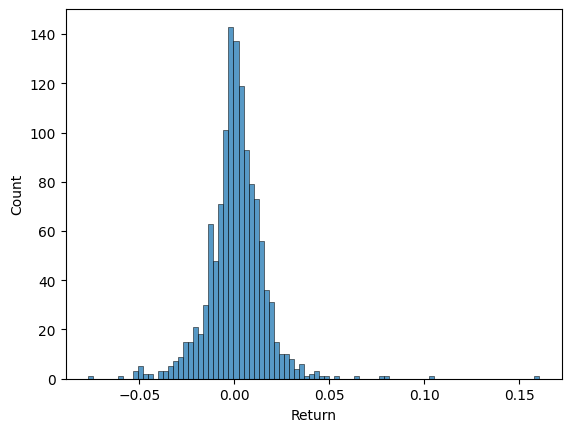

In [ ]:
import seaborn as sns
sns.histplot(data_train['Return'])

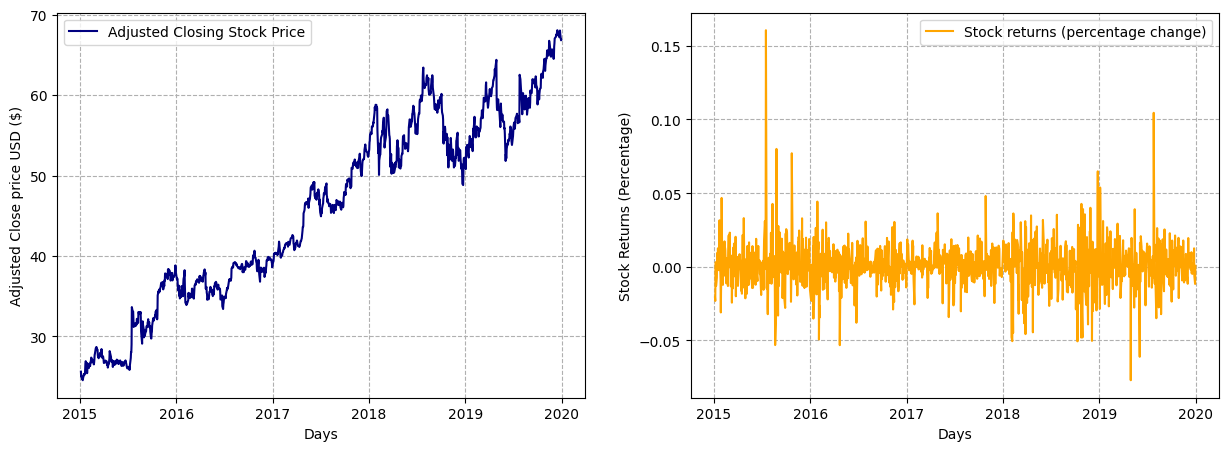

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(data_train.index, data_train['Adj Close'], label = "Adjusted Closing Stock Price", color = "navy")
plt.xlabel("Days")
plt.ylabel("Adjusted Close price USD ($)")

plt.grid(linestyle = "dashed")
plt.legend()

plt.subplot(1,2,2)
plt.plot(data_train.index, data_train['Return'], label = "Stock returns (percentage change)", color = "orange")
plt.xlabel("Days")
plt.ylabel("Stock Returns (Percentage)")

plt.grid(linestyle = "dashed")
plt.legend()

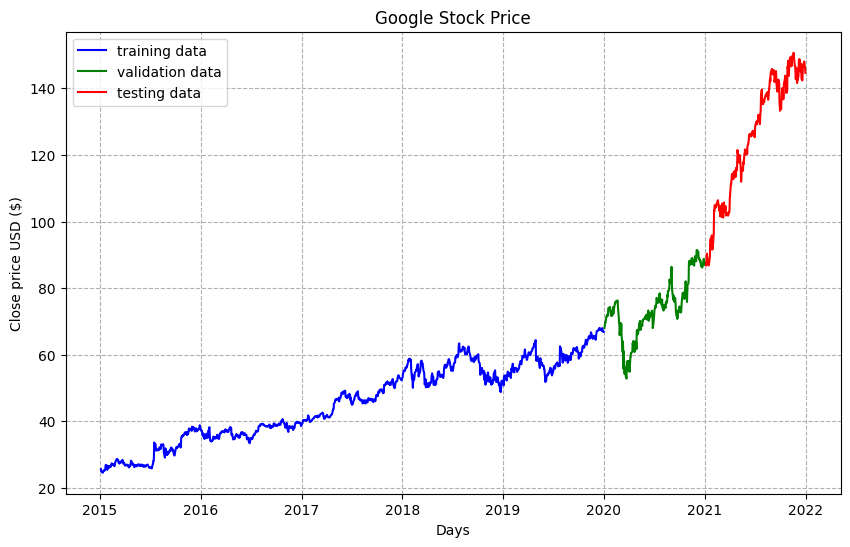

In [ ]:
plt.subplots(figsize =(10,6))
plt.plot(data_train.index, data_train['Adj Close'], label = "training data", color = "b")
plt.plot(data_val.index, data_val['Adj Close'], label = "validation data", color = "g")
plt.plot(data_test.index, data_test['Adj Close'], label = "testing data", color = "r")
plt.xlabel("Days")
plt.ylabel("Adjusted Close price USD ($)")
plt.title("Google Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.show()

In [ ]:
#Standardize data
prediction_days = 30

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#For Training data
data_train_values = data_train['Return'].values.reshape(-1,1)
data_train_scaled = scaler.fit_transform(data_train_values)


x_train = []
y_train = []

for x in range(prediction_days, len(data_train_scaled)):
    x_train.append(data_train_scaled[x-prediction_days:x, 0])
    y_train.append(data_train_scaled[x, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

#For validation data
data_val_scaled = scaler.transform(data_val['Return'].values.reshape(-1,1))
x_val = []
y_val = []

for x in range(prediction_days, len(data_val_scaled)):
    x_val.append(data_val_scaled[x-prediction_days:x, 0])
    y_val.append(data_val_scaled[x, 0])
x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0],1))

#For test data
data_test_scaled = scaler.transform(data_test['Return'].values.reshape(-1,1))
x_test = []
y_test = []

for x in range(prediction_days, len(data_test_scaled)):
    x_test.append(data_test_scaled[x-prediction_days:x, 0])
    y_test.append(data_test_scaled[x, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

# Part 1 research question: Effects of hyperparams on performance

In [ ]:
def exploring_param (hidden_units, lr, rate =0.0):
    keras.backend.clear_session()
    keras.utils.set_random_seed(100)
    #Create model
    model = Sequential()
    #Adding simpleRNN layer
    model.add(SimpleRNN(units = hidden_units, activation = "tanh",
                        input_shape = (x_train.shape[1],1),
                        dropout = rate))
    # adding the output layer
    model.add(Dense(units = 1))

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    # compiling RNN
    model.compile(
        optimizer = optimizer,
        loss = LOSS,
        metrics = METRICS)

    # fitting the RNN
    history = model.fit(x_train, y_train, validation_data = (x_val,y_val) , epochs = 50, batch_size = 128, verbose = 0)

    plt.figure(figsize = (9,6))
    plt.plot(history.history['loss'], color = "navy", label = "Training loss", linewidth = 2)
    plt.plot(history.history['val_loss'], color = "orangered", label = "Validation loss",linewidth = 2)
    plt.xlabel("Epochs")
    plt.ylabel("mse")
    plt.grid(linestyle = "dashed")
    plt.legend()
    plt.title(f'Training and validation loss for {hidden_units} units and {lr} learning rate and {rate} dropout rate')

    return history.history['loss'][-1], history.history['val_loss'][-1]

## Compare Hidden Units

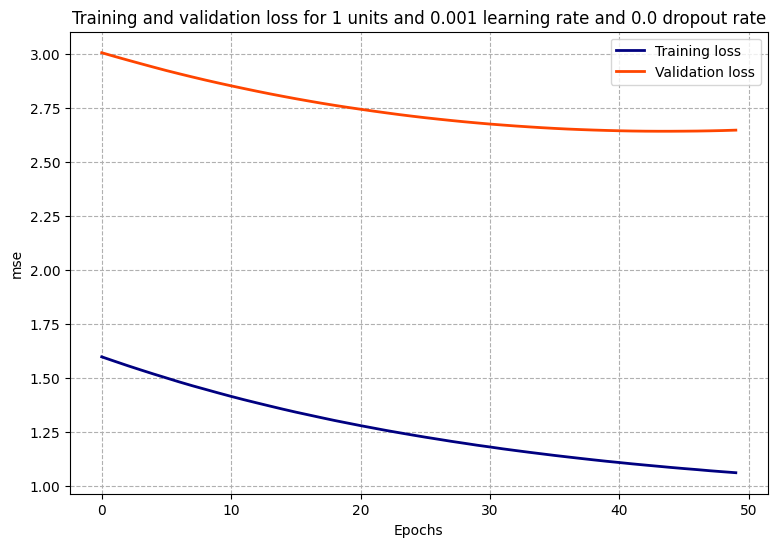

In [ ]:
loss_unit1_lre3, history_unit1_lre3 = exploring_param(hidden_units = 1, lr = 0.001)


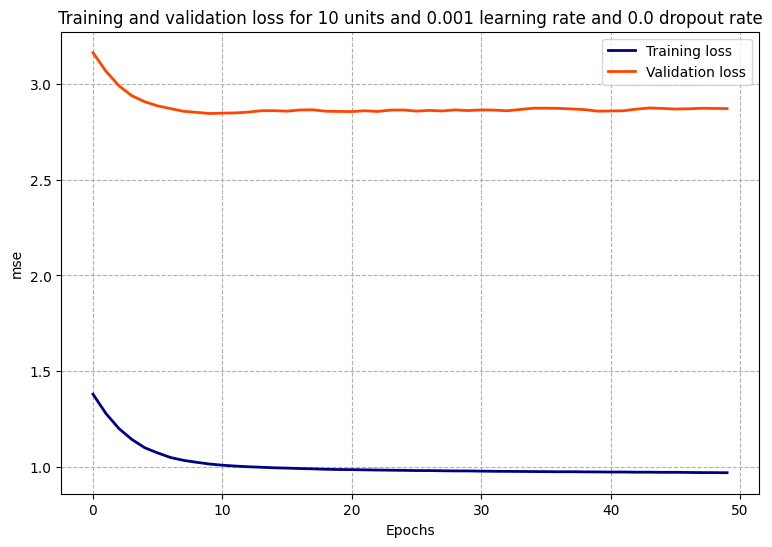

In [ ]:
loss_unit10_lre3, history_unit10_lre3 = exploring_param(hidden_units = 10, lr = 0.001)

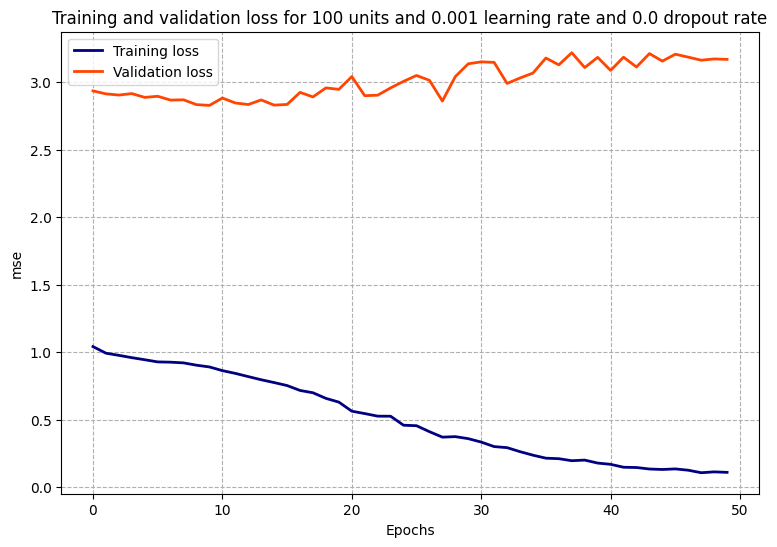

In [ ]:
loss_unit100_lre3, history_unit100_lre3 = exploring_param(hidden_units = 100, lr = 0.001)

In [ ]:
loss_unit1_lre3, loss_unit10_lre3, loss_unit100_lre3

(1.0604101419448853, 0.9698498249053955, 0.10913167893886566)

In [ ]:
history_unit1_lre3, history_unit10_lre3, history_unit100_lre3

(2.645850419998169, 2.870835065841675, 3.170535087585449)

## Comparing learning rate

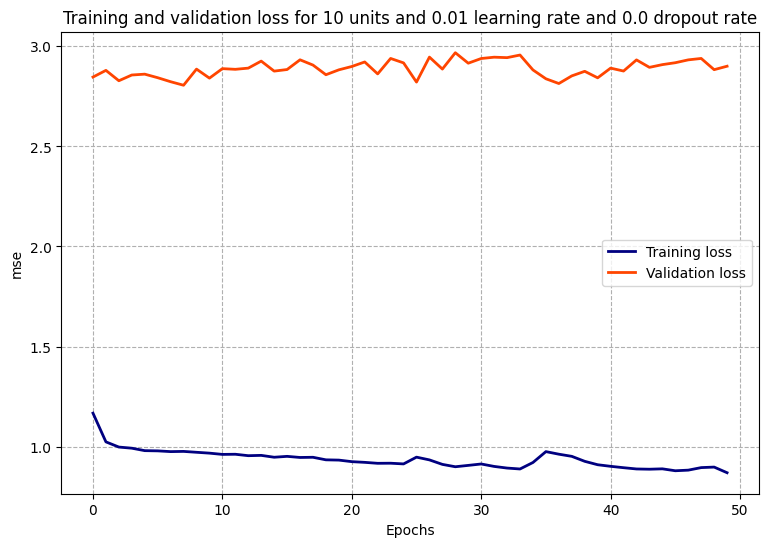

In [ ]:
loss_unit10_lre2, history_unit10_lre2 = exploring_param(hidden_units = 10, lr = 0.01)

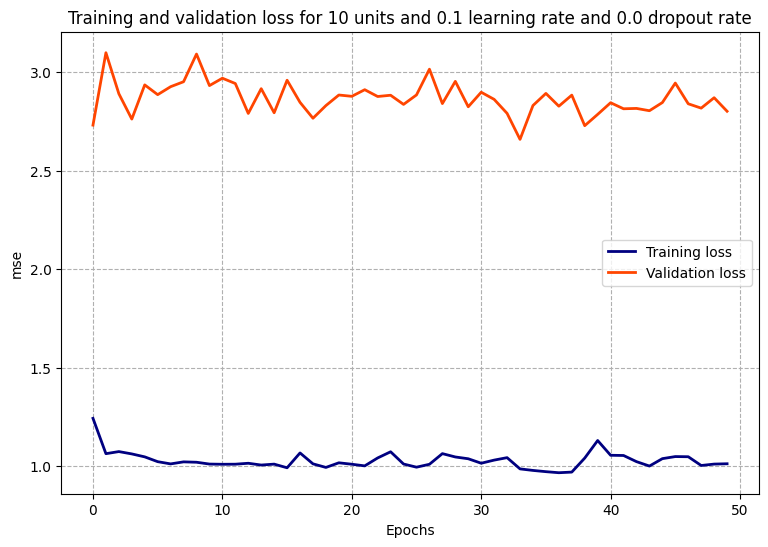

In [ ]:
loss_unit10_lre1,history_unit10_lre1 = exploring_param(hidden_units = 10, lr = 0.1)

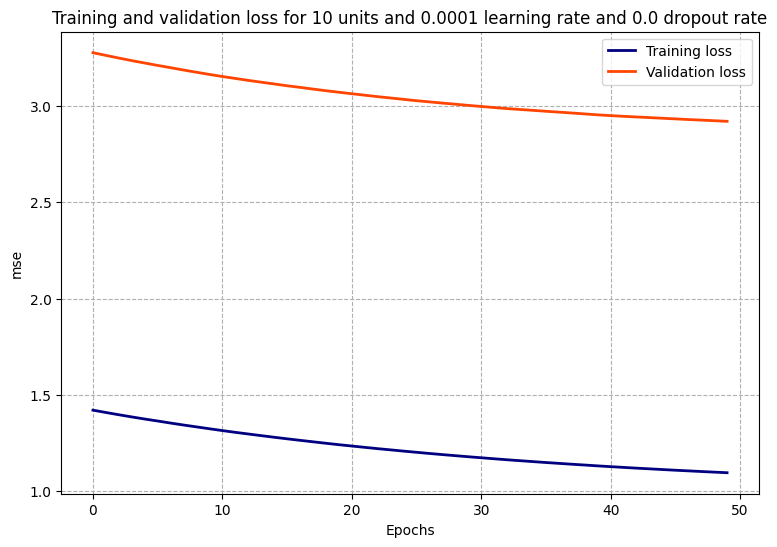

In [ ]:
loss_unit10_lre4, history_unit10_lre4 = exploring_param(hidden_units = 10, lr = 0.0001)

In [ ]:
loss_unit10_lre1, loss_unit10_lre2, loss_unit10_lre3, loss_unit10_lre4

(1.012611985206604, 0.8695746064186096, 0.9698498249053955, 1.0957469940185547)

In [ ]:
history_unit10_lre1, history_unit10_lre2, history_unit10_lre3,history_unit10_lre4

(2.800490140914917, 2.9006145000457764, 2.870835065841675, 2.920865058898926)

## Compare drop out rate

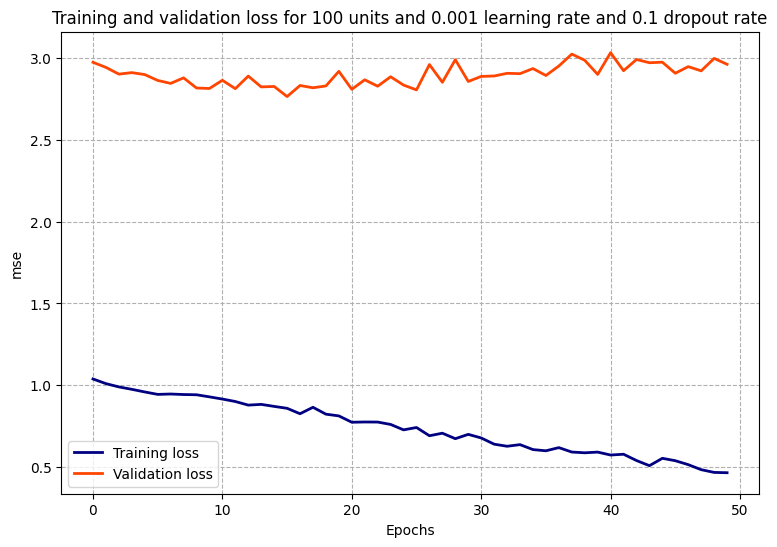

In [ ]:
loss_rate1,history_unit100_lre3_rate1 = exploring_param(hidden_units = 100, lr = 0.001, rate = 0.1)


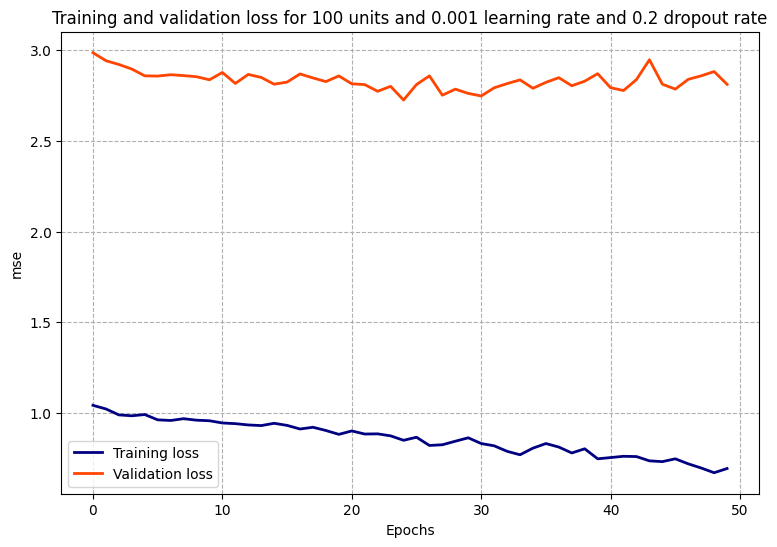

In [ ]:
loss_rate2, history_unit100_lre3_rate2 = exploring_param(hidden_units = 100, lr = 0.001, rate = 0.2)


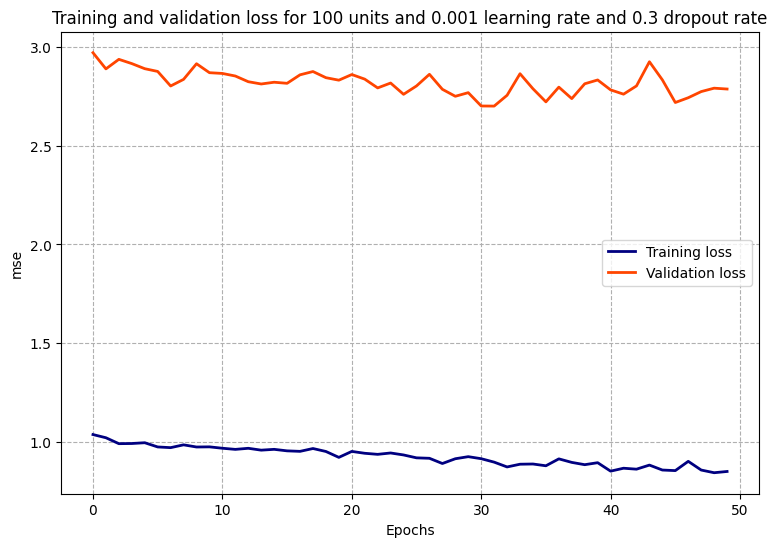

In [ ]:
loss_rate3, history_unit100_lre3_rate3 = exploring_param(hidden_units = 100, lr = 0.001, rate = 0.3)


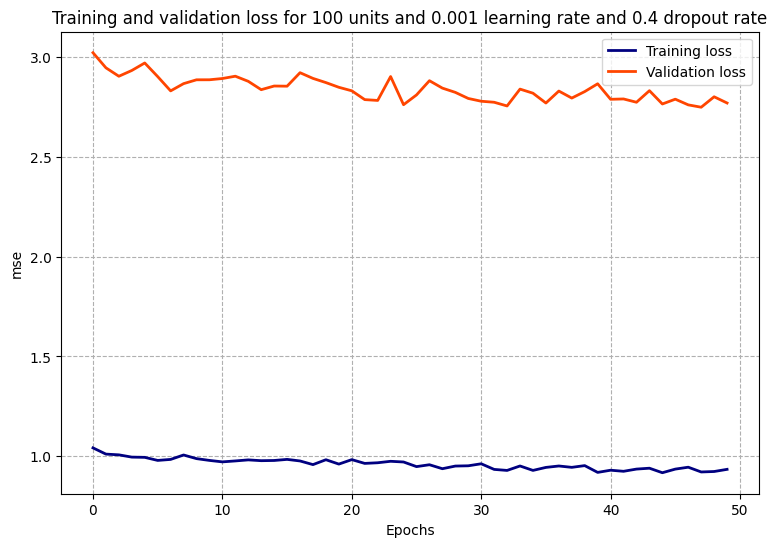

In [ ]:
loss_rate4, history_unit100_lre3_rate4 = exploring_param(hidden_units = 100, lr = 0.001, rate = 0.4)


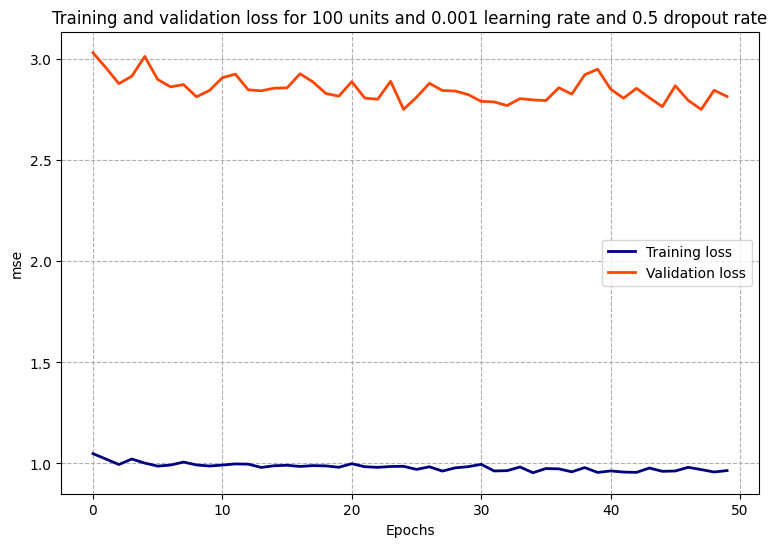

In [ ]:
loss_rate5, history_unit100_lre3_rate5 = exploring_param(hidden_units = 100, lr = 0.001, rate = 0.5)


In [ ]:
history_unit100_lre3, history_unit100_lre3_rate1, history_unit100_lre3_rate2, history_unit100_lre3_rate3, history_unit100_lre3_rate4, history_unit100_lre3_rate5

(3.170535087585449,
 2.9611496925354004,
 2.811980962753296,
 2.7884390354156494,
 2.7689478397369385,
 2.8148608207702637)

In [ ]:
loss_unit100_lre3, loss_rate1, loss_rate2, loss_rate3, loss_rate4, loss_rate5

(0.10913167893886566,
 0.46530279517173767,
 0.6937310099601746,
 0.8487111926078796,
 0.9350206851959229,
 0.9650065302848816)

# Part 2 research question: Comparing 3 models with Naive prediction

## Hyperparameter tuning

In [ ]:
def model_builder(hp):
  keras.backend.clear_session()
  keras.utils.set_random_seed(100)
  model = Sequential()
  hp_units = hp.Choice('units', values=[10, 30, 50, 100])
  hp_dropout = hp.Choice('rate', values = [0.0, 0.2, 0.4])
  model.add(SimpleRNN(units = hp_units, activation = "tanh",
                      return_sequences = True,
                      input_shape = (x_train.shape[1],1), dropout = hp_dropout))
  # for i in range(hp.Int('layers', 0, 2)):
  #     model.add(SimpleRNN(units = hp_units, activation = "tanh",
  #                         return_sequences = True))
  model.add(SimpleRNN(units = hp_units, activation = "tanh",
                          return_sequences = True))
  model.add(SimpleRNN(units = hp_units, activation = "tanh",
                          return_sequences = True))
  model.add(SimpleRNN(units = hp_units, activation = "tanh"))

  model.add(Dense(units = 1))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=LOSS,
                metrics=METRICS)
  return model

def model_builder_GRU(hp):
  keras.backend.clear_session()
  keras.utils.set_random_seed(100)
  model = Sequential()
  hp_units = hp.Choice('units', values=[10, 30, 50, 100])
  hp_dropout = hp.Choice('rate', values = [0.0, 0.2, 0.4])
  model.add(GRU(units = hp_units,activation = "tanh",
                return_sequences = True,
                input_shape = (x_train.shape[1],1), dropout = hp_dropout))
  # for i in range(hp.Int('layers', 0, 2)):
  model.add(GRU(units = hp_units, activation = "tanh",
                          return_sequences = True))
  model.add(GRU(units = hp_units, activation = "tanh",
                          return_sequences = True))
  model.add(GRU(units = hp_units, activation = "tanh"))
  model.add(Dense(units = 1))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=LOSS,
                metrics=METRICS)
  return model

def model_builder_LSTM(hp):
  keras.backend.clear_session()
  keras.utils.set_random_seed(100)
  model = Sequential()
  hp_units = hp.Choice('units', values=[10, 30, 50, 100])
  hp_dropout = hp.Choice('rate', values = [0.0, 0.2, 0.4])
  model.add(LSTM(units = hp_units,activation = "tanh",
                 return_sequences = True,
                 input_shape = (x_train.shape[1],1), dropout = hp_dropout))
  # for i in range(hp.Int('layers', 0, 2)):
  model.add(LSTM(units = hp_units, activation = "tanh",
                      return_sequences = True))
  model.add(LSTM(units = hp_units, activation = "tanh",
                      return_sequences = True))
  model.add(LSTM(units = hp_units, activation = "tanh"))
  model.add(Dense(units = 1))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=LOSS,
                metrics=METRICS)
  return model



In [ ]:
tuner_RNN = kt.Hyperband(
    model_builder,
    objective='val_loss',
    overwrite = True,
    max_epochs=500)

tuner_GRU = kt.Hyperband(
    model_builder_GRU,
    objective='val_loss',
    overwrite = True,
    max_epochs=500)

tuner_LSTM = kt.Hyperband(
    model_builder_LSTM,
    objective='val_loss',
    overwrite = True,
    max_epochs=500)

In [ ]:
tuner_RNN.search(x_train, y_train ,validation_data = (x_val, y_val) , epochs = 50, batch_size = len(x_train), callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Trial 35 Complete [00h 00m 04s]
val_loss: 2.974153757095337

Best val_loss So Far: 2.865957260131836
Total elapsed time: 00h 02m 20s


In [ ]:
tuner_GRU.search(x_train, y_train ,validation_data = (x_val, y_val) ,epochs=50, batch_size = len(x_train), callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Trial 35 Complete [00h 00m 12s]
val_loss: 2.788775682449341

Best val_loss So Far: 2.7734057903289795
Total elapsed time: 00h 05m 21s


In [ ]:
tuner_LSTM.search(x_train, y_train ,validation_data = (x_val, y_val) ,epochs=50, batch_size = len(x_train), callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Trial 35 Complete [00h 00m 11s]
val_loss: 2.7838833332061768

Best val_loss So Far: 2.78196120262146
Total elapsed time: 00h 06m 30s


## Summary tuner

In [ ]:
tuner_RNN.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0030 summary
Hyperparameters:
units: 30
rate: 0.2
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.865957260131836

Trial 0015 summary
Hyperparameters:
units: 30
rate: 0.0
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.8675427436828613

Trial 0008 summary
Hyperparameters:
units: 100
rate: 0.4
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.8826582431793213

Trial 0000 summary
Hyperparameters:
units: 100
rate: 0.0
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.897995710372925

Trial 0028 summary
Hyperparameters:
units: 100
rate: 0.2
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.8993101119995117

Trial 0022

In [ ]:
tuner_GRU.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0002 summary
Hyperparameters:
units: 10
rate: 0.2
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.7734057903289795

Trial 0020 summary
Hyperparameters:
units: 10
rate: 0.4
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.7734100818634033

Trial 0031 summary
Hyperparameters:
units: 10
rate: 0.0
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.773418426513672

Trial 0006 summary
Hyperparameters:
units: 10
rate: 0.2
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.7740554809570312

Trial 0019 summary
Hyperparameters:
units: 10
rate: 0.4
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.7741003036499023

Trial 001

In [ ]:
tuner_LSTM.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0002 summary
Hyperparameters:
units: 10
rate: 0.2
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.78196120262146

Trial 0020 summary
Hyperparameters:
units: 10
rate: 0.4
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.7819621562957764

Trial 0019 summary
Hyperparameters:
units: 10
rate: 0.4
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.7819769382476807

Trial 0031 summary
Hyperparameters:
units: 10
rate: 0.0
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.781977653503418

Trial 0006 summary
Hyperparameters:
units: 10
rate: 0.2
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 2.781984329223633

Trial 0017 s

## Training

In [ ]:
best_RNN=tuner_RNN.get_best_hyperparameters(num_trials=1)[0]
model_RNN = tuner_RNN.hypermodel.build(best_RNN)
history_RNN = model_RNN.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, batch_size = len(x_train),
                    callbacks=[keras.callbacks.EarlyStopping('val_loss',patience=50)]
                    )

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 2.6493 - mae: 1.2633 - val_loss: 1.2958 - val_mae: 0.9042
Epoch 2/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.5377 - mae: 0.9304 - val_loss: 1.0548 - val_mae: 0.8019
Epoch 3/1000
1/1 [==============================] - 0s 112ms/step - loss: 1.2797 - mae: 0.8184 - val_loss: 0.8822 - val_mae: 0.7140
Epoch 4/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.1068 - mae: 0.7427 - val_loss: 0.9832 - val_mae: 0.7646
Epoch 5/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.1453 - mae: 0.7669 - val_loss: 0.9176 - val_mae: 0.7257
Epoch 6/1000
1/1 [==============================] - 0s 106ms/step - loss: 1.0520 - mae: 0.7130 - val_loss: 0.8717 - val_mae: 0.6953
Epoch 7/1000
1/1 [==============================] - 0s 110ms/step - loss: 1.0388 - mae: 0.7005 - val_loss: 0.8601 - val_mae: 0.6854
Epoch 8/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.039

In [ ]:
best_GRU=tuner_GRU.get_best_hyperparameters(num_trials=1)[0]
model_GRU = tuner_GRU.hypermodel.build(best_GRU)
history_GRU = model_GRU.fit(x_train, y_train, validation_data = (x_test,y_test) , epochs = 1000, batch_size = len(x_train),
                    callbacks=[keras.callbacks.EarlyStopping('val_loss',patience=10)]
                    )

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.9960 - mae: 0.6697 - val_loss: 0.8061 - val_mae: 0.6655
Epoch 2/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.9977 - mae: 0.6699 - val_loss: 0.8060 - val_mae: 0.6654
Epoch 3/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.9965 - mae: 0.6700 - val_loss: 0.8059 - val_mae: 0.6653
Epoch 4/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.9961 - mae: 0.6697 - val_loss: 0.8058 - val_mae: 0.6653
Epoch 5/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.9962 - mae: 0.6701 - val_loss: 0.8058 - val_mae: 0.6653
Epoch 6/1000
1/1 [==============================] - 0s 133ms/step - loss: 0.9972 - mae: 0.6702 - val_loss: 0.8057 - val_mae: 0.6653
Epoch 7/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.9971 - mae: 0.6699 - val_loss: 0.8057 - val_mae: 0.6653
Epoch 8/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.995

In [ ]:
best_LSTM=tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]
model_LSTM = tuner_LSTM.hypermodel.build(best_LSTM)
history_LSTM = model_LSTM.fit(x_train, y_train, validation_data = (x_test,y_test) , epochs = 1000, batch_size = len(x_train),
                    callbacks=[keras.callbacks.EarlyStopping('val_loss',patience=10)]
                    )

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 1.0000 - mae: 0.6719 - val_loss: 0.8100 - val_mae: 0.6670
Epoch 2/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.0006 - mae: 0.6720 - val_loss: 0.8100 - val_mae: 0.6670
Epoch 3/1000
1/1 [==============================] - 0s 146ms/step - loss: 1.0008 - mae: 0.6724 - val_loss: 0.8100 - val_mae: 0.6670
Epoch 4/1000
1/1 [==============================] - 0s 140ms/step - loss: 0.9993 - mae: 0.6715 - val_loss: 0.8100 - val_mae: 0.6670
Epoch 5/1000
1/1 [==============================] - 0s 143ms/step - loss: 0.9991 - mae: 0.6717 - val_loss: 0.8100 - val_mae: 0.6670
Epoch 6/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.0017 - mae: 0.6723 - val_loss: 0.8100 - val_mae: 0.6670
Epoch 7/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.9978 - mae: 0.6713 - val_loss: 0.8099 - val_mae: 0.6670
Epoch 8/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.000

## Model summary

In [ ]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 30)            960       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 6481 (25.32 KB)
Trainable params: 6481 (25.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 10)            390       
                                                                 
 gru_1 (GRU)                 (None, 30, 10)            660       
                                                                 
 gru_2 (GRU)                 (None, 30, 10)            660       
                                                                 
 gru_3 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 2381 (9.30 KB)
Trainable params: 2381 (9.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 30, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 30, 10)            840       
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3011 (11.76 KB)
Trainable params: 3011 (11.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Results on Stock Returns

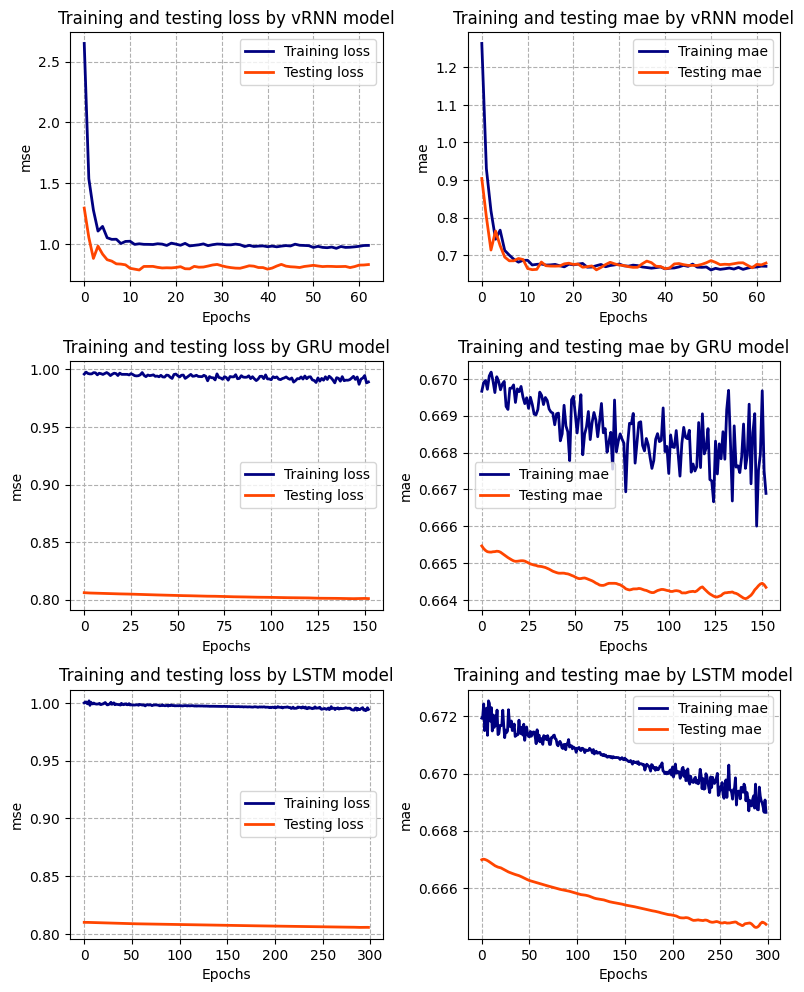

In [ ]:
plt.style.use('default')
#plt.figure(figsize = (8,8))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (8,10))

plt.subplot(3,2,1)
plt.plot(history_RNN.history['loss'], color = "navy", label = "Training loss", linewidth = 2)
plt.plot(history_RNN.history['val_loss'], color = "orangered", label = "Testing loss",linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("mse")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Training and testing loss by vRNN model")

plt.subplot(3,2,2)
plt.plot(history_RNN.history['mae'], color = "navy", label = "Training mae", linewidth = 2)
plt.plot(history_RNN.history['val_mae'], color = "orangered", label = "Testing mae",linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Training and testing mae by vRNN model")

plt.subplot(3,2,3)
plt.plot(history_GRU.history['loss'], color = "navy", label = "Training loss", linewidth = 2)
plt.plot(history_GRU.history['val_loss'], color = "orangered", label = "Testing loss",linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("mse")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Training and testing loss by GRU model")

plt.subplot(3,2,4)
plt.plot(history_GRU.history['mae'], color = "navy", label = "Training mae", linewidth = 2)
plt.plot(history_GRU.history['val_mae'], color = "orangered", label = "Testing mae",linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Training and testing mae by GRU model")

plt.subplot(3,2,5)
plt.plot(history_LSTM.history['loss'], color = "navy", label = "Training loss", linewidth = 2)
plt.plot(history_LSTM.history['val_loss'], color = "orangered", label = "Testing loss",linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("mse")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Training and testing loss by LSTM model")

plt.subplot(3,2,6)
plt.plot(history_LSTM.history['mae'], color = "navy", label = "Training mae", linewidth = 2)
plt.plot(history_LSTM.history['val_mae'], color = "orangered", label = "Testing mae",linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Training and testing mae by LSTM model")

fig.tight_layout(pad = 1)
plt.show()

In [ ]:
# Predict
y_test_pred_RNN = model_RNN.predict(x_test)
y_test_pred_GRU = model_GRU.predict(x_test)
y_test_pred_LSTM = model_LSTM.predict(x_test)

#Inverse to actual return
y_test_pred_RNN_inv = scaler.inverse_transform(y_test_pred_RNN)
y_test_pred_GRU_inv = scaler.inverse_transform(y_test_pred_GRU)
y_test_pred_LSTM_inv = scaler.inverse_transform(y_test_pred_LSTM)

y_test_inv = scaler.inverse_transform(y_test)

#Moving Average
x_test_mva = pd.DataFrame(x_test.reshape(-1,prediction_days))
y_test_mva = x_test_mva.mean(axis=1).values.reshape(-1,1)
y_test_mva_inv = scaler.inverse_transform(y_test_mva)


7/7 [==============================] - 1s 13ms/step


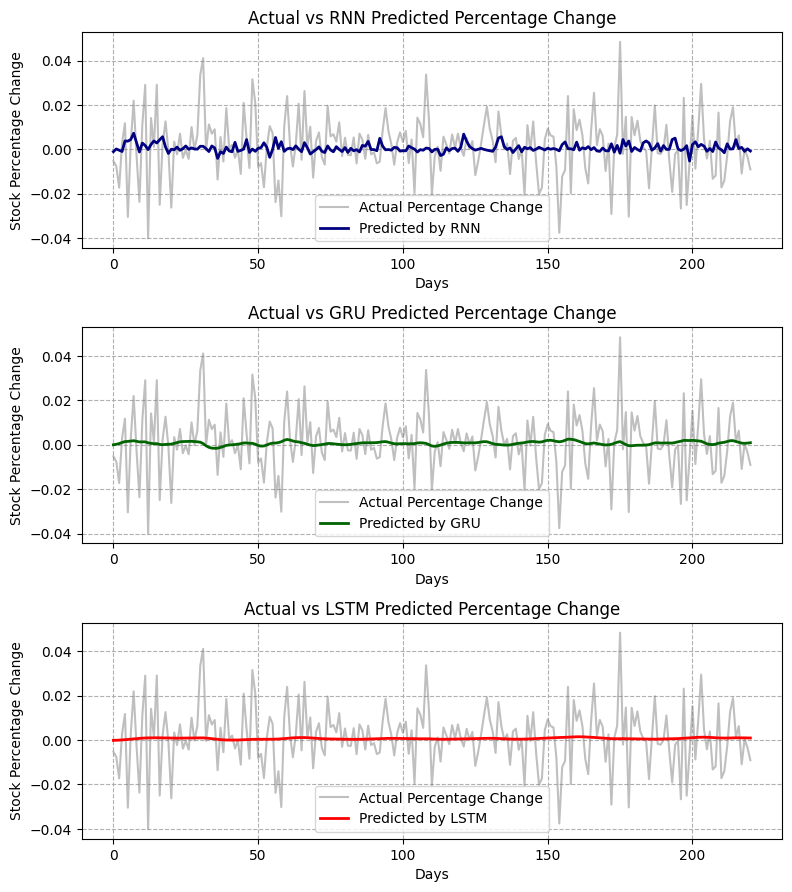

In [ ]:
# plt.figure(figsize = (30,10))
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,9))
plt.subplot(3, 1, 1)
plt.plot(y_test_inv, color = "grey", label = "Actual Percentage Change", alpha = 0.5)
plt.plot(y_test_pred_RNN_inv, color = "navy", label = "Predicted by RNN", linewidth = 2)
plt.xlabel("Days")
plt.ylabel("Stock Percentage Change")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs RNN Predicted Percentage Change")

plt.subplot(3, 1, 2)
plt.plot(y_test_inv, color = "grey", label = "Actual Percentage Change", alpha = 0.5)
plt.plot(y_test_pred_GRU_inv, color = "darkgreen", label = "Predicted by GRU", linewidth = 2)
plt.xlabel("Days")
plt.ylabel("Stock Percentage Change")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs GRU Predicted Percentage Change")

plt.subplot(3, 1, 3)
plt.plot(y_test_inv, color = "grey", label = "Actual Percentage Change", alpha = 0.5)
plt.plot(y_test_pred_LSTM_inv, color = "red", label = "Predicted by LSTM", linewidth = 2)
plt.xlabel("Days")
plt.ylabel("Stock Percentage Change")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs LSTM Predicted Percentage Change")

fig.tight_layout(pad = 1)
plt.show()

### Regression matrix : MAPE/MAE/MSE

In [ ]:
y_naive = np.zeros((221,1))

In [ ]:
print("RNN:",np.mean(keras.metrics.mean_absolute_error(y_test_inv, y_test_pred_RNN_inv)))
print("GRU:",np.mean(keras.metrics.mean_absolute_error(y_test_inv, y_test_pred_GRU_inv)))
print("LSTM:",np.mean(keras.metrics.mean_absolute_error(y_test_inv, y_test_pred_LSTM_inv)))
print("Naive:",np.mean(keras.metrics.mean_absolute_error(y_test_inv, y_naive)))

RNN: 0.010268644
GRU: 0.010042015
LSTM: 0.010047736
Naive: 0.010161872744157639


In [ ]:
print("RNN:",np.mean(keras.metrics.mean_absolute_percentage_error(y_test_inv, y_test_pred_RNN_inv)))
print("GRU:",np.mean(keras.metrics.mean_absolute_percentage_error(y_test_inv, y_test_pred_GRU_inv)))
print("LSTM:",np.mean(keras.metrics.mean_absolute_percentage_error(y_test_inv, y_test_pred_LSTM_inv)))
print("naive:",np.mean(keras.metrics.mean_absolute_percentage_error(y_test_inv, y_naive)))


RNN: 139.84254
GRU: 114.29829
LSTM: 112.240135
naive: 100.0


In [ ]:
print("RNN:",np.mean(keras.metrics.mean_squared_error(y_test_inv, y_test_pred_RNN_inv)))
print("GRU:",np.mean(keras.metrics.mean_squared_error(y_test_inv, y_test_pred_GRU_inv)))
print("LSTM:",np.mean(keras.metrics.mean_squared_error(y_test_inv, y_test_pred_LSTM_inv)))
print("naive:",np.mean(keras.metrics.mean_squared_error(y_test_inv, y_naive)))

RNN: 0.00019003192
GRU: 0.00018300838
LSTM: 0.0001840828
naive: 0.00018629303434934436


In [ ]:
test_data = data_test[prediction_days:]
test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
test_data['pred_pct_LSTM'] = y_test_pred_LSTM_inv.reshape(-1).tolist()
test_data['pred_pct_mva'] = y_test_mva_inv.reshape(-1).tolist()

test_data['adj price prev'] = test_data['Adj Close'].shift(1)

test_data['predicted_RNN'] = test_data['adj price prev'] * (1+test_data['pred_pct_RNN'])
test_data['predicted_GRU'] = test_data['adj price prev'] * (1+test_data['pred_pct_GRU'])
test_data['predicted_LSTM'] = test_data['adj price prev'] * (1+test_data['pred_pct_LSTM'])
test_data['predicted_mva'] = test_data['adj price prev'] * (1+test_data['pred_pct_mva'])
test_data['predicted_naive'] = test_data['adj price prev']

test_data.drop(index=test_data.index[0], axis=0, inplace=True)

test_predicted_RNN = test_data['predicted_RNN'].values
test_predicted_GRU = test_data['predicted_GRU'].values
test_predicted_LSTM = test_data['predicted_LSTM'].values
test_predicted_mva = test_data['predicted_mva'].values
test_predicted_naive = test_data['predicted_naive'].values

test_original = test_data['Adj Close'].values

<ipython-input-46-e0e2b88d469d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
<ipython-input-46-e0e2b88d469d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
<ipython-input-46-e0e2b88d469d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

### Classification Matrix: MDA (accuracy)

In [ ]:
def convertToDirection (inputlist):
    inputlist = inputlist.reshape(-1).tolist()
    outputlist = ["Pos" if i > 0 else "Neg" for i in inputlist]
    return outputlist

In [ ]:
test_direction_original = convertToDirection(y_test_inv)
test_direction_RNN = convertToDirection(y_test_pred_RNN_inv)
test_direction_GRU = convertToDirection(y_test_pred_GRU_inv)
test_direction_LSTM = convertToDirection(y_test_pred_LSTM_inv)

In [ ]:
from sklearn.metrics import accuracy_score
print('RNN:',accuracy_score(test_direction_original,test_direction_RNN))
print('GRU:',accuracy_score(test_direction_original,test_direction_GRU))
print('LSTM:',accuracy_score(test_direction_original,test_direction_LSTM))

RNN: 0.5158371040723982
GRU: 0.5565610859728507
LSTM: 0.583710407239819


In [ ]:
from sklearn.metrics import confusion_matrix
conf_RNN = confusion_matrix(test_direction_original,test_direction_RNN)
conf_GRU = confusion_matrix(test_direction_original,test_direction_GRU)
conf_LSTM = confusion_matrix(test_direction_original,test_direction_LSTM)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

def confusionMatrixPlot(conf_matrix):
    class_names = ['Negative','Positive']
    fig, ax = plot_confusion_matrix(conf_matrix, figsize=(6, 6), fontcolor_threshold=0.8, class_names = class_names)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

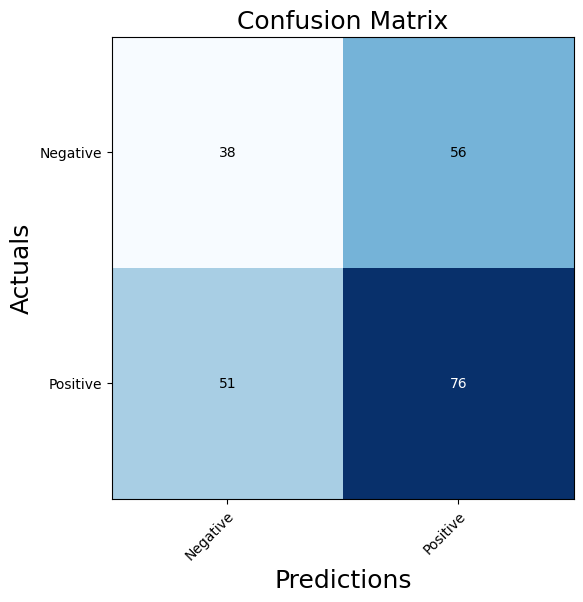

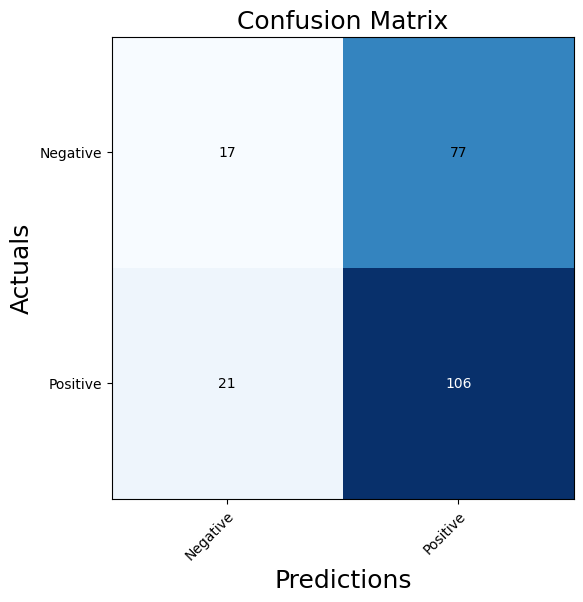

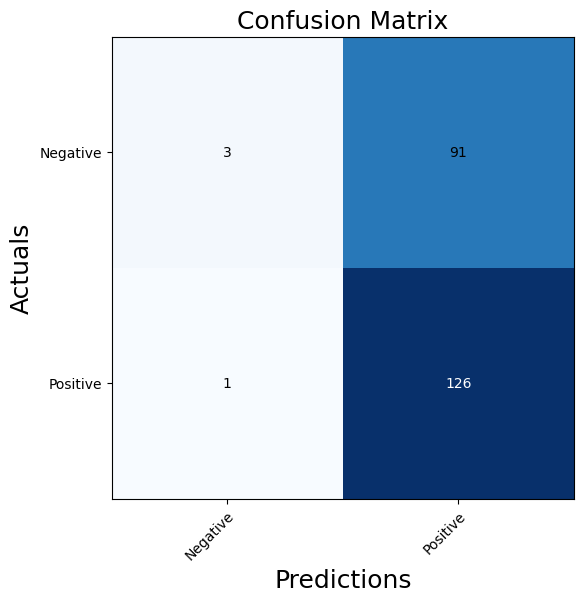

In [ ]:
confusionMatrixPlot(conf_RNN)
confusionMatrixPlot(conf_GRU)
confusionMatrixPlot(conf_LSTM)

# Results on Stock Price

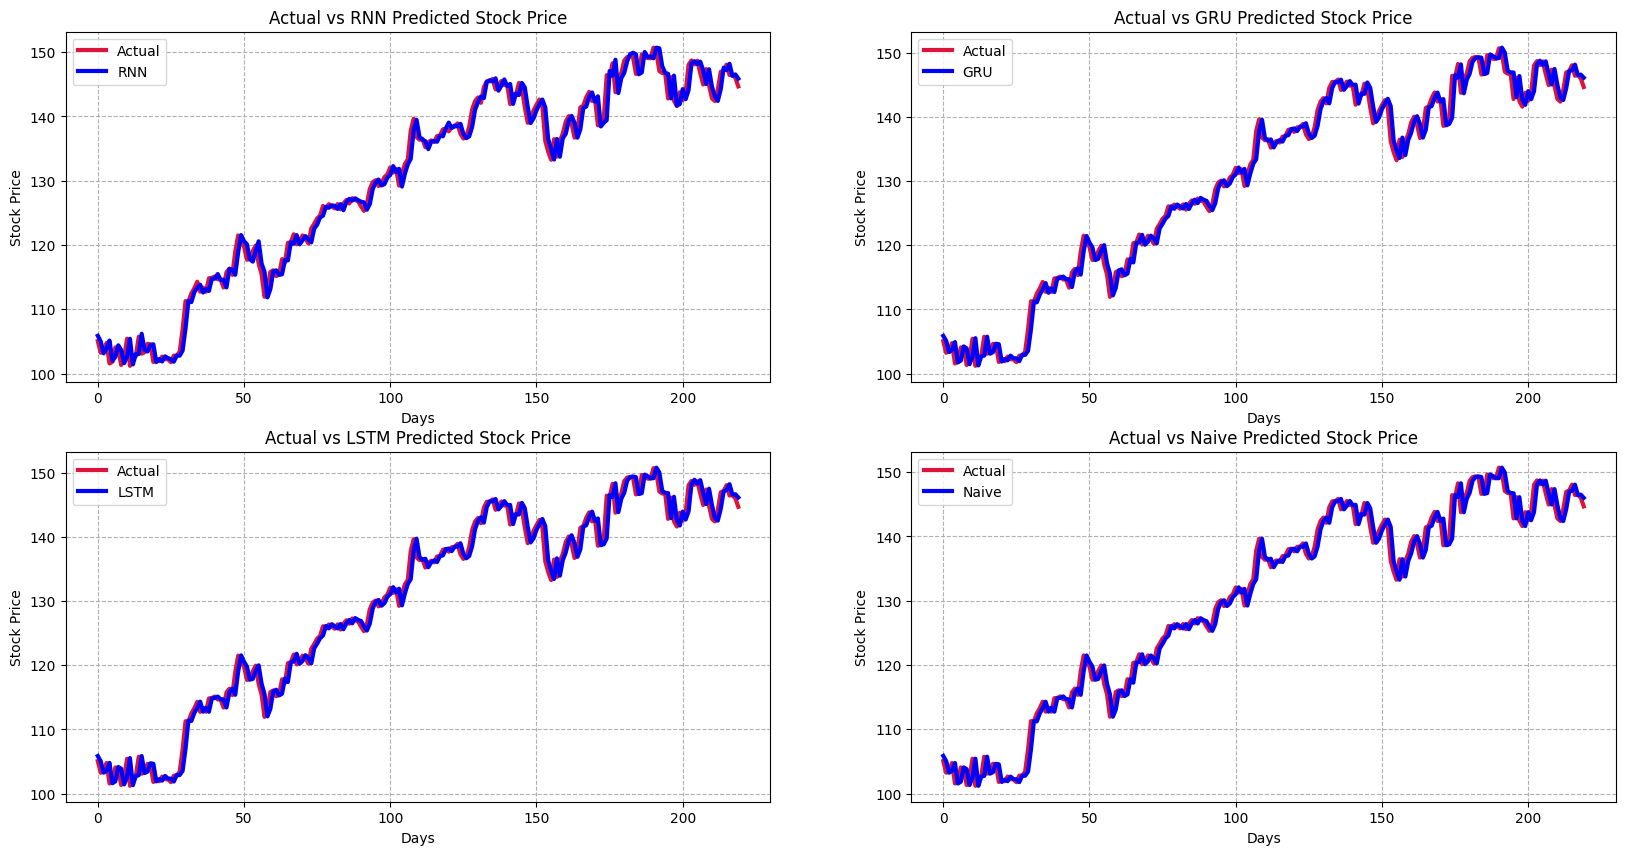

In [116]:
# plt.figure(figsize = (30,10))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
plt.subplot(2, 2, 1)
plt.plot(test_original, color = "crimson", label = "Actual", linewidth = 3)
plt.plot(test_predicted_RNN, color = "blue", label = "RNN", linewidth = 3)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs RNN Predicted Stock Price")

plt.subplot(2, 2, 2)
plt.plot(test_original, color = "crimson", label = "Actual",linewidth = 3)
plt.plot(test_predicted_GRU, color = "blue", label = "GRU", linewidth = 3)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs GRU Predicted Stock Price")

plt.subplot(2, 2, 3)
plt.plot(test_original, color = "crimson", label = "Actual", linewidth = 3)
plt.plot(test_predicted_LSTM, color = "blue", label = "LSTM", linewidth = 3)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs LSTM Predicted Stock Price")

plt.subplot(2, 2, 4)
plt.plot(test_original, color = "crimson", label = "Actual", linewidth = 3)
plt.plot(test_predicted_naive, color = "blue", label = "Naive", linewidth = 3)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs Naive Predicted Stock Price")

plt.show()

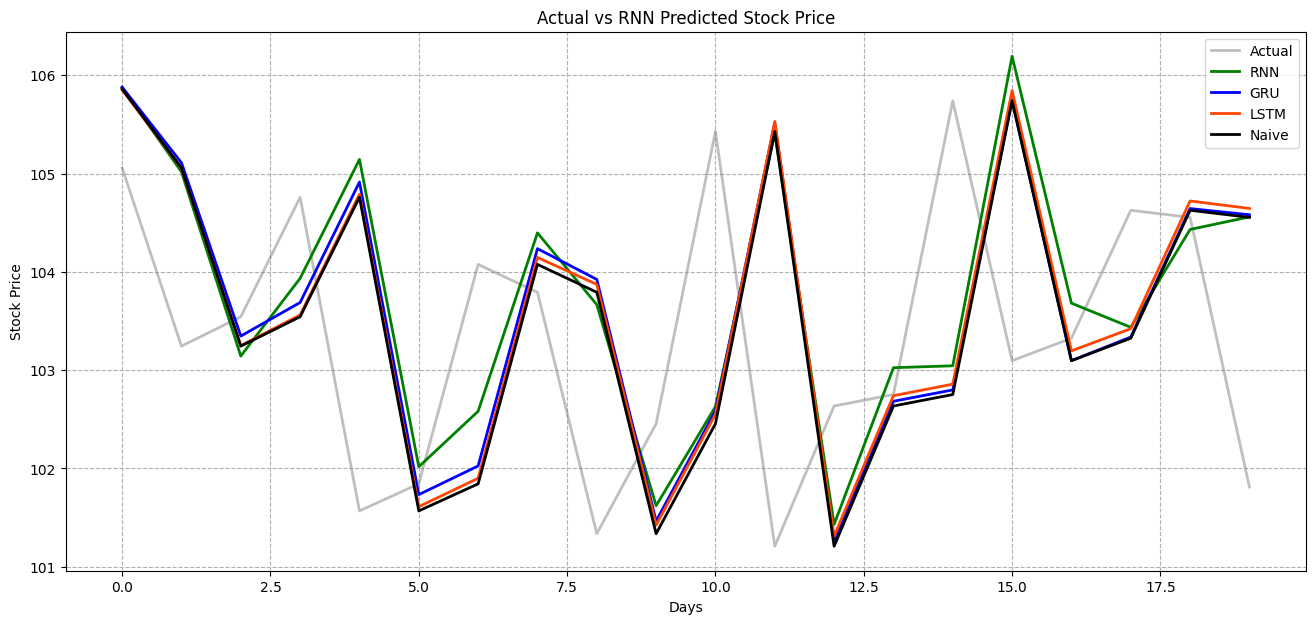

In [ ]:
plt.figure(figsize = (16,7))
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,20))
# plt.subplot(4, 1, 1)
plt.plot(test_original[0:20], color = "grey", label = "Actual", linewidth = 2, alpha = 0.5)
plt.plot(test_predicted_RNN[0:20], color = "green", label = "RNN", linewidth = 2)
plt.plot(test_predicted_GRU[0:20], color = "blue", label = "GRU", linewidth = 2)
plt.plot(test_predicted_LSTM[0:20], color = "orangered", label = "LSTM", linewidth = 2)
plt.plot(test_predicted_naive[0:20], color = "black", label = "Naive", linewidth = 2)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs RNN Predicted Stock Price")


fig.tight_layout(pad = 1)
plt.show()

In [ ]:
# prompt: write a function to calculate MAPE between actual and predicted price and return a corresponding list

def calculate_MAPE(actual_prices, predicted_prices):
    """
    Calculates Mean Absolute Percentage Error between actual and predicted prices.

    Args:
        actual_prices (list): List of actual prices.
        predicted_prices (list): List of predicted prices.

    Returns:
        list: List of MAPE values.
    """

    mape_values = []
    for actual_price, predicted_price in zip(actual_prices, predicted_prices):
        mape_value = abs(actual_price - predicted_price) / actual_price * 100
        mape_values.append(mape_value)

    return mape_values


In [ ]:
# prompt: write a function to calculate MSE between actual and predicted price and return a corresponding list

def calculate_MSE(actual_prices, predicted_prices):
    """
    Calculates Mean Squared Error between actual and predicted prices.

    Args:
        actual_prices (list): List of actual prices.
        predicted_prices (list): List of predicted prices.

    Returns:
        list: List of MSE values.
    """

    mse_values = []
    for actual_price, predicted_price in zip(actual_prices, predicted_prices):
        mse_value = (actual_price - predicted_price) ** 2
        mse_values.append(mse_value)

    return mse_values


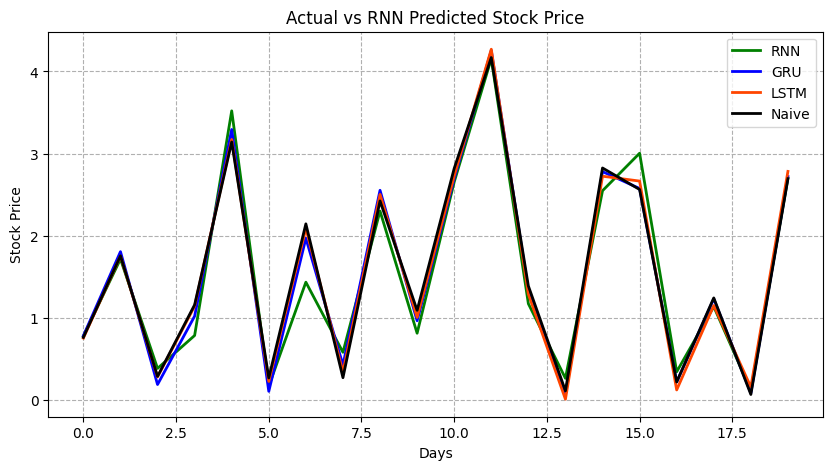

In [ ]:
plt.figure(figsize = (10,5))
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,20))
# plt.subplot(4, 1, 1)
#plt.plot(, color = "grey", label = "Actual", linewidth = 2, alpha = 0.5)
plt.plot(calculate_MAPE(test_original,test_predicted_RNN)[0:20], color = "green", label = "RNN", linewidth = 2)
plt.plot(calculate_MAPE(test_original,test_predicted_GRU)[0:20], color = "blue", label = "GRU", linewidth = 2)
plt.plot(calculate_MAPE(test_original,test_predicted_LSTM)[0:20], color = "orangered", label = "LSTM", linewidth = 2)
plt.plot(calculate_MAPE(test_original,test_predicted_naive)[0:20], color = "black", label = "Naive", linewidth = 2)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()
plt.title("Actual vs RNN Predicted Stock Price")


fig.tight_layout(pad = 1)
plt.show()

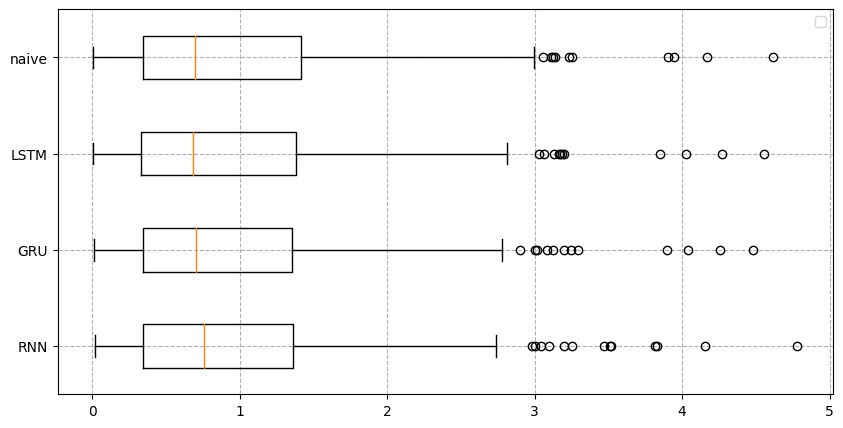

In [ ]:
plt.figure(figsize = (10,5))
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,20))
# plt.subplot(4, 1, 1)
#plt.plot(, color = "grey", label = "Actual", linewidth = 2, alpha = 0.5)

data = [calculate_MAPE(test_original,test_predicted_RNN),
        calculate_MAPE(test_original,test_predicted_GRU),
        calculate_MAPE(test_original,test_predicted_LSTM),
        calculate_MAPE(test_original,test_predicted_naive)]
plt.boxplot(data, vert = 0)


#plt.ylabel("Stock Price")
plt.grid(linestyle = "dashed")
plt.legend()

plt.yticks([1,2,3,4],['RNN','GRU','LSTM',"naive"])

fig.tight_layout(pad = 1)
plt.show()

In [117]:
print("RNN:",keras.metrics.mean_absolute_percentage_error(test_original, test_predicted_RNN).numpy())
print("GRU:",keras.metrics.mean_absolute_percentage_error(test_original, test_predicted_GRU).numpy())
print("LSTM:",keras.metrics.mean_absolute_percentage_error(test_original,test_predicted_LSTM).numpy())
print("Naive:",keras.metrics.mean_absolute_percentage_error(test_original,test_predicted_naive).numpy())

RNN: 1.028329857546169
GRU: 1.005123182732861
LSTM: 1.0056830923289053
Naive: 1.0163361326785676


In [118]:
print("RNN:",keras.metrics.mean_absolute_error(test_original, test_predicted_RNN).numpy())
print("GRU:",keras.metrics.mean_absolute_error(test_original, test_predicted_GRU).numpy())
print("LSTM:",keras.metrics.mean_absolute_error(test_original,test_predicted_LSTM).numpy())
print("Naive:",keras.metrics.mean_absolute_error(test_original,test_predicted_naive).numpy())

RNN: 1.325108934805557
GRU: 1.2917902060780968
LSTM: 1.2926476218697622
Naive: 1.3066200256347655


In [119]:
print("RNN:",keras.metrics.mean_squared_error(test_original, test_predicted_RNN).numpy())
print("GRU:",keras.metrics.mean_squared_error(test_original, test_predicted_GRU).numpy())
print("LSTM:",keras.metrics.mean_squared_error(test_original,test_predicted_LSTM).numpy())
print("Naive:",keras.metrics.mean_squared_error(test_original,test_predicted_naive).numpy())

RNN: 3.143109322861359
GRU: 3.001288888246714
LSTM: 3.0231261745249887
Naive: 3.0509786461813335


# Testing other Stock (Define a function)

In [ ]:
def testing_stock(company,model_RNN = model_RNN, model_GRU = model_GRU, model_LSTM = model_LSTM):
  yf.pdr_override()
  #Load data

  start_test = dt.datetime(2021,1,1)
  end_test = dt.datetime(2022,1,1)

  data_test = pdr.get_data_yahoo(company, start=start_test, end=end_test)
  # Preprocessing
  data_test['Return'] = data_test['Adj Close'].pct_change()
  data_test.dropna(inplace=True)
  # Transform
  data_test_scaled = scaler.transform(data_test['Return'].values.reshape(-1,1))

  # Preparing test data
  x_test = []
  y_test = []

  for x in range(prediction_days, len(data_test_scaled)):
      x_test.append(data_test_scaled[x-prediction_days:x, 0])
      y_test.append(data_test_scaled[x, 0])
  x_test, y_test = np.array(x_test), np.array(y_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0],1))


  # #Fit model RNN
  # history_test_RNN = model_RNN.fit(x_test, y_test, epochs = 50, batch_size = len(x_test),
  #                   verbose = 0
  #                   )
  # #Fit model GRU
  # history_test_GRU = model_GRU.fit(x_test, y_test, epochs = 50, batch_size = len(x_test),
  #                   verbose = 0
  #                   )
  # #Fit model LSTM
  # history_test_LSTM = model_LSTM.fit(x_test, y_test, epochs = 50, batch_size = len(x_test),
  #                   verbose = 0
  #                   )


  #Predict
  test_predicted_RNN = model_RNN.predict(x_test)
  test_predicted_GRU = model_GRU.predict(x_test)
  test_predicted_LSTM = model_LSTM.predict(x_test)

  #Inverse transform
  y_test_pred_RNN_inv = scaler.inverse_transform(test_predicted_RNN)
  y_test_pred_GRU_inv = scaler.inverse_transform(test_predicted_GRU)
  y_test_pred_LSTM_inv = scaler.inverse_transform(test_predicted_LSTM)
  y_test_inv = scaler.inverse_transform(y_test)

  test_direction_original = convertToDirection(y_test_inv)
  test_direction_RNN = convertToDirection(y_test_pred_RNN_inv)
  test_direction_GRU = convertToDirection(y_test_pred_GRU_inv)
  test_direction_LSTM = convertToDirection(y_test_pred_LSTM_inv)


  print('RNN:',accuracy_score(test_direction_original,test_direction_RNN))
  print('GRU:',accuracy_score(test_direction_original,test_direction_GRU))
  print('LSTM:',accuracy_score(test_direction_original,test_direction_LSTM))

  conf_RNN = confusion_matrix(test_direction_original,test_direction_RNN)
  conf_GRU = confusion_matrix(test_direction_original,test_direction_GRU)
  conf_LSTM = confusion_matrix(test_direction_original,test_direction_LSTM)

  confusionMatrixPlot(conf_RNN)
  confusionMatrixPlot(conf_GRU)
  confusionMatrixPlot(conf_LSTM)

  #Plot
  fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,9))
  plt.subplot(3, 1, 1)
  plt.plot(y_test_inv, color = "grey", label = "Actual Percentage Change", alpha = 0.5)
  plt.plot(y_test_pred_RNN_inv, color = "navy", label = "Predicted by RNN", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Percentage Change")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("Actual vs RNN Predicted Percentage Change")

  plt.subplot(3, 1, 2)
  plt.plot(y_test_inv, color = "grey", label = "Actual Percentage Change", alpha = 0.5)
  plt.plot(y_test_pred_GRU_inv, color = "darkgreen", label = "Predicted by GRU", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Percentage Change")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("Actual vs GRU Predicted Percentage Change")

  plt.subplot(3, 1, 3)
  plt.plot(y_test_inv, color = "grey", label = "Actual Percentage Change", alpha = 0.5)
  plt.plot(y_test_pred_LSTM_inv, color = "red", label = "Predicted by LSTM", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Percentage Change")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("Actual vs LSTM Predicted Percentage Change")

  fig.tight_layout(pad = 1)
  plt.show()

  #Moving Average calculate
  x_test_mva = pd.DataFrame(x_test.reshape(-1,prediction_days))
  y_test_mva = x_test_mva.mean(axis=1).values.reshape(-1,1)
  y_test_mva_inv = scaler.inverse_transform(y_test_mva)

  #Getting Stock data
  test_data = data_test[prediction_days:]
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
  test_data['pred_pct_LSTM'] = y_test_pred_LSTM_inv.reshape(-1).tolist()
  test_data['pred_pct_mva'] = y_test_mva_inv.reshape(-1).tolist()

  test_data['adj price prev'] = test_data['Adj Close'].shift(1)

  test_data['predicted_RNN'] = test_data['adj price prev'] * (1+test_data['pred_pct_RNN'])
  test_data['predicted_GRU'] = test_data['adj price prev'] * (1+test_data['pred_pct_GRU'])
  test_data['predicted_LSTM'] = test_data['adj price prev'] * (1+test_data['pred_pct_LSTM'])
  test_data['predicted_mva'] = test_data['adj price prev'] * (1+test_data['pred_pct_mva'])
  test_data['predicted_naive'] = test_data['adj price prev']

  test_data.drop(index=test_data.index[0], axis=0, inplace=True)

  test_predicted_RNN = test_data['predicted_RNN'].values
  test_predicted_GRU = test_data['predicted_GRU'].values
  test_predicted_LSTM = test_data['predicted_LSTM'].values
  test_predicted_mva = test_data['predicted_mva'].values
  test_predicted_naive = test_data['predicted_naive'].values

  test_original = test_data['Adj Close'].values

  # Plot actual price
  plt.figure(figsize = (16,7))
  plt.plot(test_original[0:30], color = "grey", label = "Actual", linewidth = 2, alpha = 0.5)
  plt.plot(test_predicted_RNN[0:30], color = "green", label = "RNN", linewidth = 2)
  plt.plot(test_predicted_GRU[0:30], color = "blue", label = "GRU", linewidth = 2)
  plt.plot(test_predicted_LSTM[0:30], color = "orangered", label = "LSTM", linewidth = 2)
  plt.plot(test_predicted_naive[0:30], color = "black", label = "Naive", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("Actual vs RNN Predicted Stock Price")

  plt.show()

  # Plot Mean abs percentage error
  plt.figure(figsize = (10,5))
  # fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,20))
  # plt.subplot(4, 1, 1)
  #plt.plot(, color = "grey", label = "Actual", linewidth = 2, alpha = 0.5)
  plt.plot(calculate_MAPE(test_original,test_predicted_RNN)[0:50], color = "green", label = "RNN", linewidth = 2)
  plt.plot(calculate_MAPE(test_original,test_predicted_GRU)[0:50], color = "blue", label = "GRU", linewidth = 2)
  plt.plot(calculate_MAPE(test_original,test_predicted_LSTM)[0:50], color = "orangered", label = "LSTM", linewidth = 2)
  plt.plot(calculate_MAPE(test_original,test_predicted_naive)[0:50], color = "black", label = "Moving Average", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("Mean Absolute Percentage Error")

  plt.show()

  #Calculate Mean abs percentage error
  print("MAPE:")
  print("RNN:",keras.metrics.mean_absolute_percentage_error(test_original, test_predicted_RNN).numpy())
  print("GRU:",keras.metrics.mean_absolute_percentage_error(test_original, test_predicted_GRU).numpy())
  print("LSTM:",keras.metrics.mean_absolute_percentage_error(test_original,test_predicted_LSTM).numpy())
  print("Moving Average:",keras.metrics.mean_absolute_percentage_error(test_original,test_predicted_mva).numpy())
  print("Naive:",keras.metrics.mean_absolute_percentage_error(test_original,test_predicted_naive).numpy())
  print()
  #Calculate mean absolute error
  print("MAE:")
  print("RNN:",keras.metrics.mean_absolute_error(test_original, test_predicted_RNN).numpy())
  print("GRU:",keras.metrics.mean_absolute_error(test_original, test_predicted_GRU).numpy())
  print("LSTM:",keras.metrics.mean_absolute_error(test_original,test_predicted_LSTM).numpy())
  print("Moving Average:",keras.metrics.mean_absolute_error(test_original,test_predicted_mva).numpy())
  print("Naive:",keras.metrics.mean_absolute_error(test_original,test_predicted_naive).numpy())
  print()
  #Calculate mean squared error
  print("MSE:")
  print("RNN:",keras.metrics.mean_squared_error(test_original, test_predicted_RNN).numpy())
  print("GRU:",keras.metrics.mean_squared_error(test_original, test_predicted_GRU).numpy())
  print("LSTM:",keras.metrics.mean_squared_error(test_original,test_predicted_LSTM).numpy())
  print("Moving Average:",keras.metrics.mean_squared_error(test_original,test_predicted_mva).numpy())
  print("Naive:",keras.metrics.mean_squared_error(test_original,test_predicted_naive).numpy())
  print()


  fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,20))
  plt.subplot(4, 1, 1)
  plt.plot(test_original, color = "crimson", label = "Actual", linewidth = 2)
  plt.plot(test_predicted_RNN, color = "blue", label = "RNN", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("RNN Predicted Stock Price")

  plt.subplot(4, 1, 2)
  plt.plot(test_original, color = "crimson", label = "Actual",linewidth = 2)
  plt.plot(test_predicted_GRU, color = "blue", label = "GRU", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("GRU Predicted Stock Price")

  plt.subplot(4, 1, 3)
  plt.plot(test_original, color = "crimson", label = "Actual", linewidth = 2)
  plt.plot(test_predicted_LSTM, color = "blue", label = "LSTM", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("LSTM Predicted Stock Price")

  plt.subplot(4, 1, 4)
  plt.plot(test_original, color = "crimson", label = "Actual", linewidth = 2)
  plt.plot(test_predicted_naive, color = "blue", label = "Naive", linewidth = 2)
  plt.xlabel("Days")
  plt.ylabel("Stock Price")
  plt.grid(linestyle = "dashed")
  plt.legend()
  plt.title("Naive Predicted Stock Price")

  fig.tight_layout(pad = 1)
  plt.show()


[*********************100%%**********************]  1 of 1 completed
7/7 [==============================] - 0s 11ms/step
RNN: 0.6108597285067874
GRU: 0.49321266968325794
LSTM: 0.5565610859728507


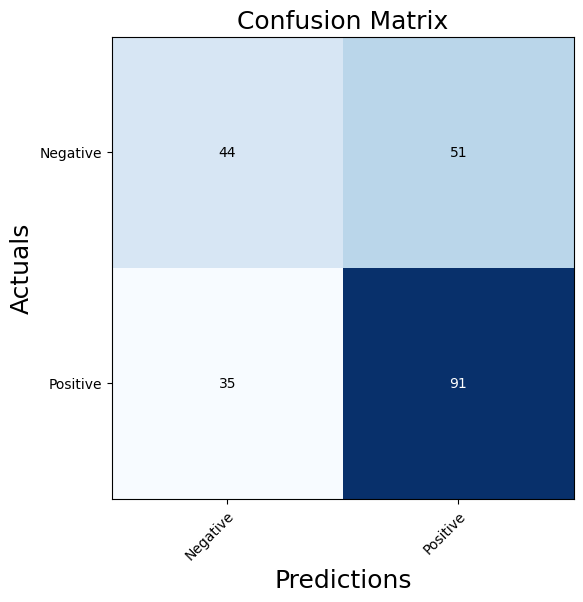

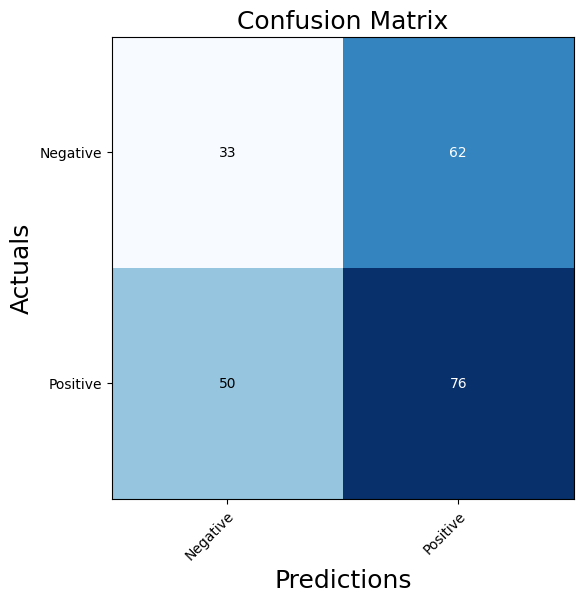

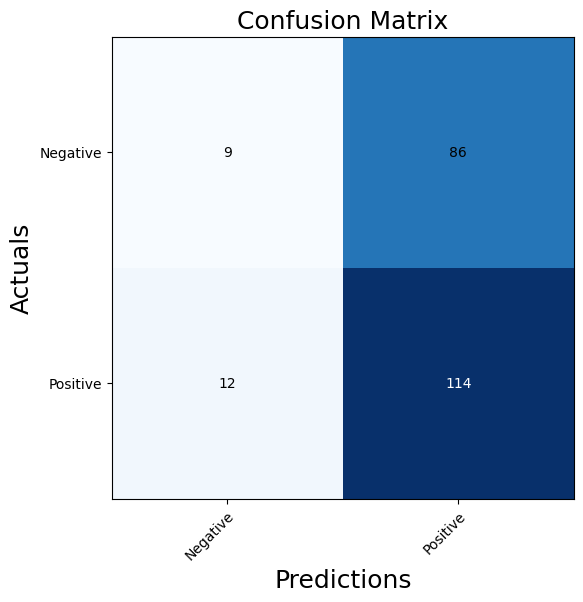

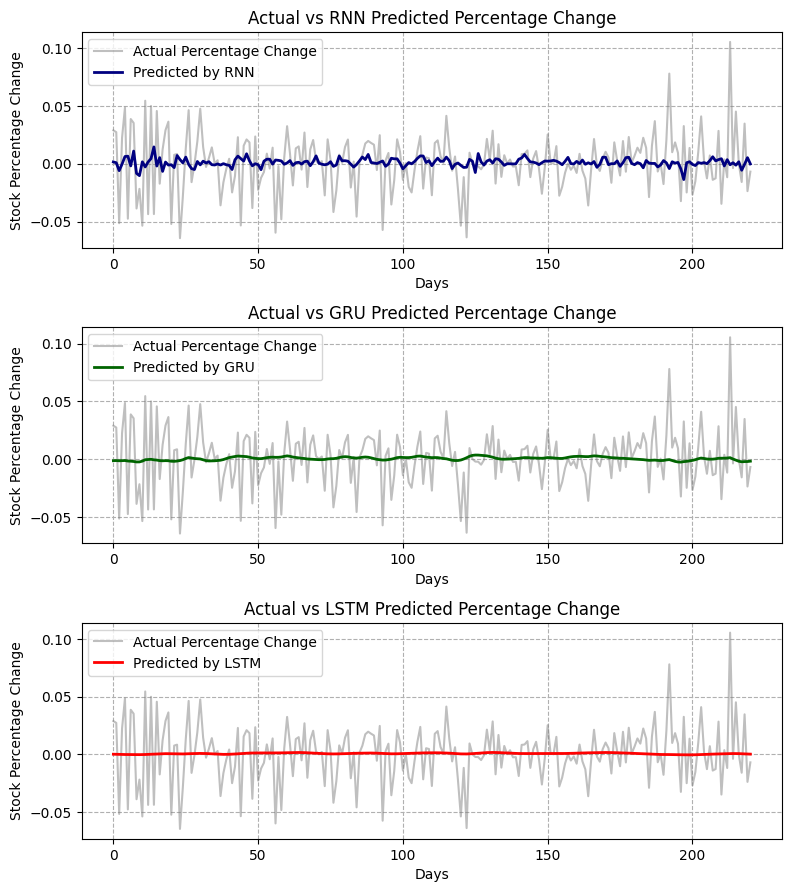

<ipython-input-82-20f777ec946d>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

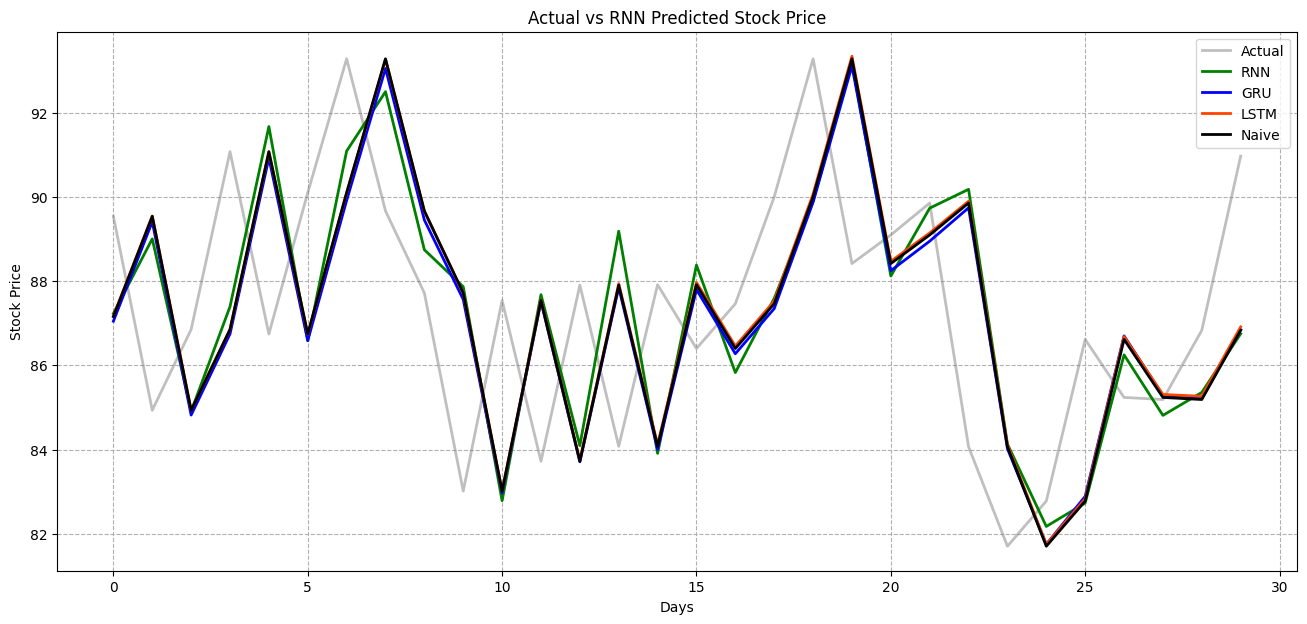

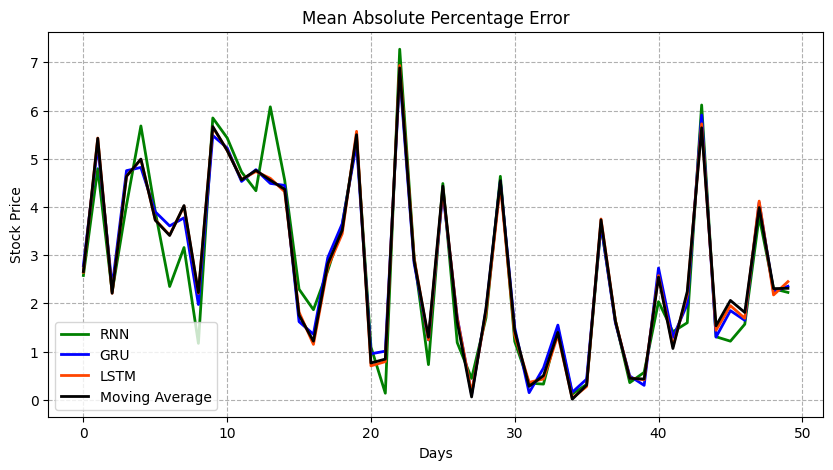

MAPE:
RNN: 1.8153853494930663
GRU: 1.8527462803150305
LSTM: 1.843617137612576
Moving Average: 1.8927373651025017
Naive: 1.8507766014950875

MAE:
RNN: 1.4713187399132799
GRU: 1.501089459021768
LSTM: 1.493848654719451
Moving Average: 1.5321764650458098
Naive: 1.500185810435902

MSE:
RNN: 4.207602745003263
GRU: 4.165789155483207
LSTM: 4.176374336568833
Moving Average: 4.307332472716284
Naive: 4.180857143702981



<ipython-input-82-20f777ec946d>:191: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)
<ipython-input-82-20f777ec946d>:209: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 3)


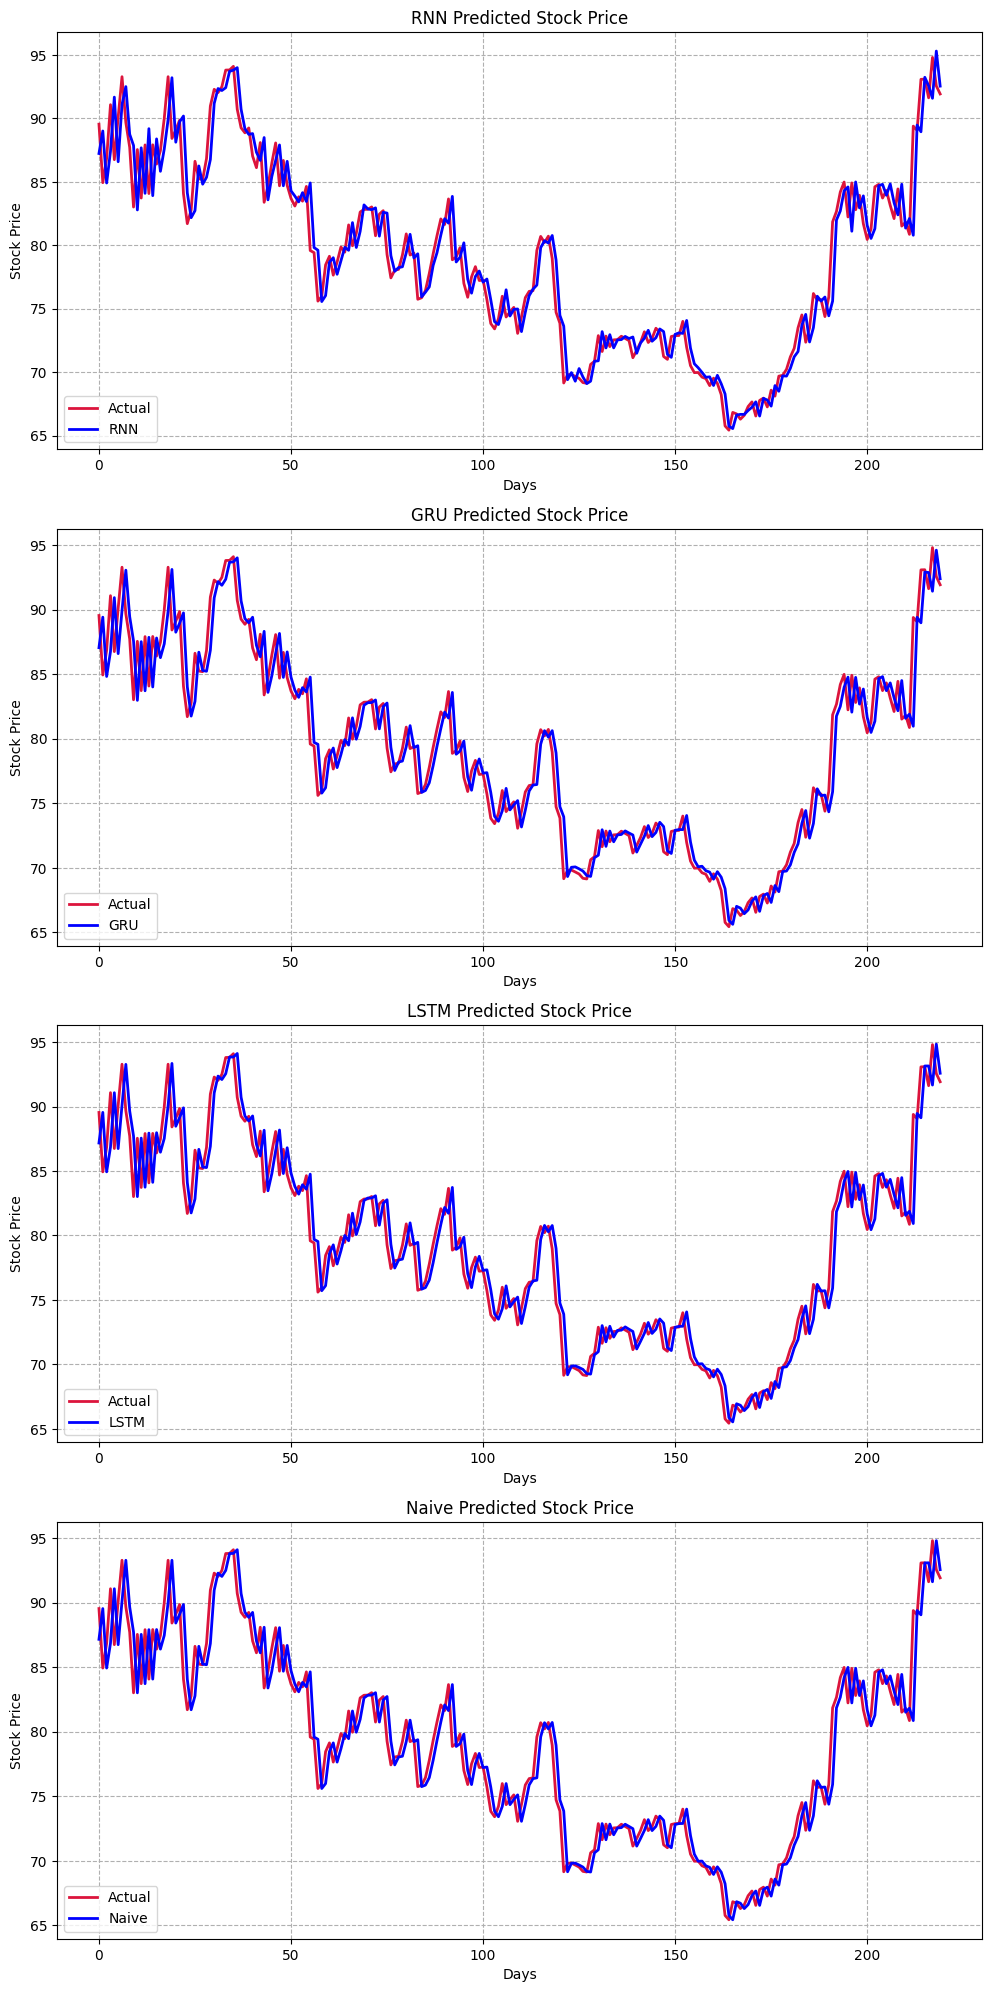

In [ ]:
testing_stock("MU")

[*********************100%%**********************]  1 of 1 completed
7/7 [==============================] - 0s 11ms/step
RNN: 0.49321266968325794
GRU: 0.5610859728506787
LSTM: 0.5656108597285068


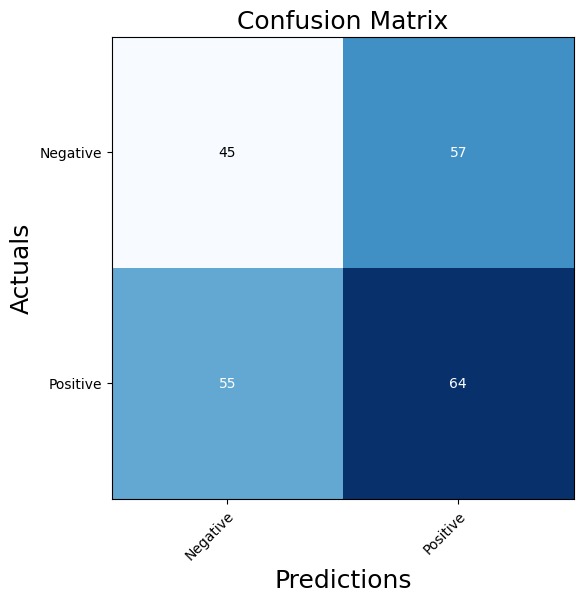

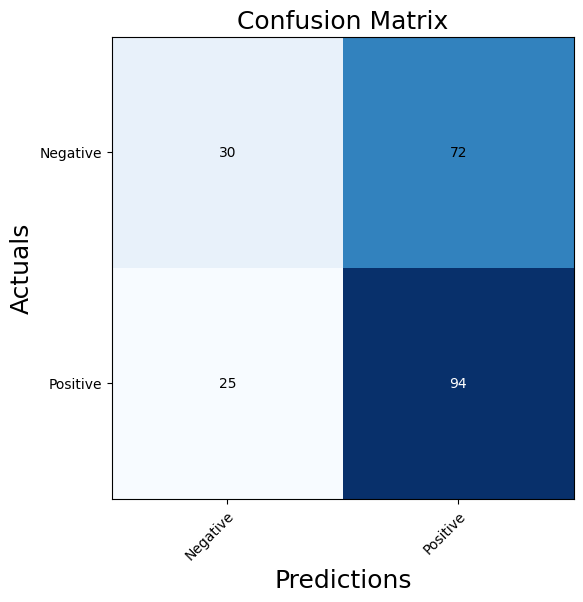

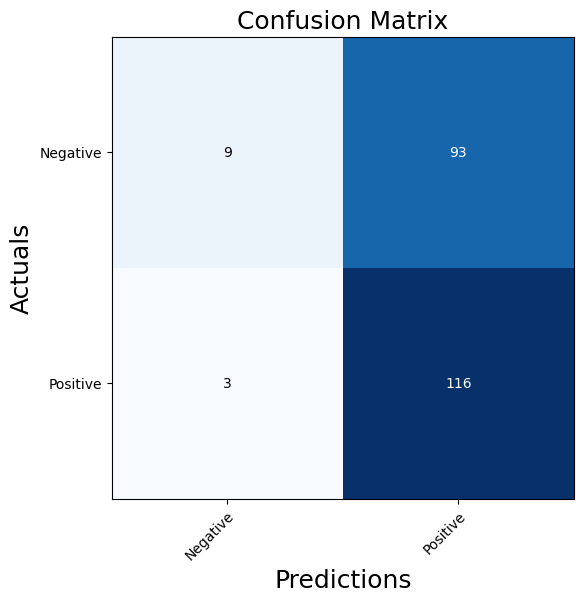

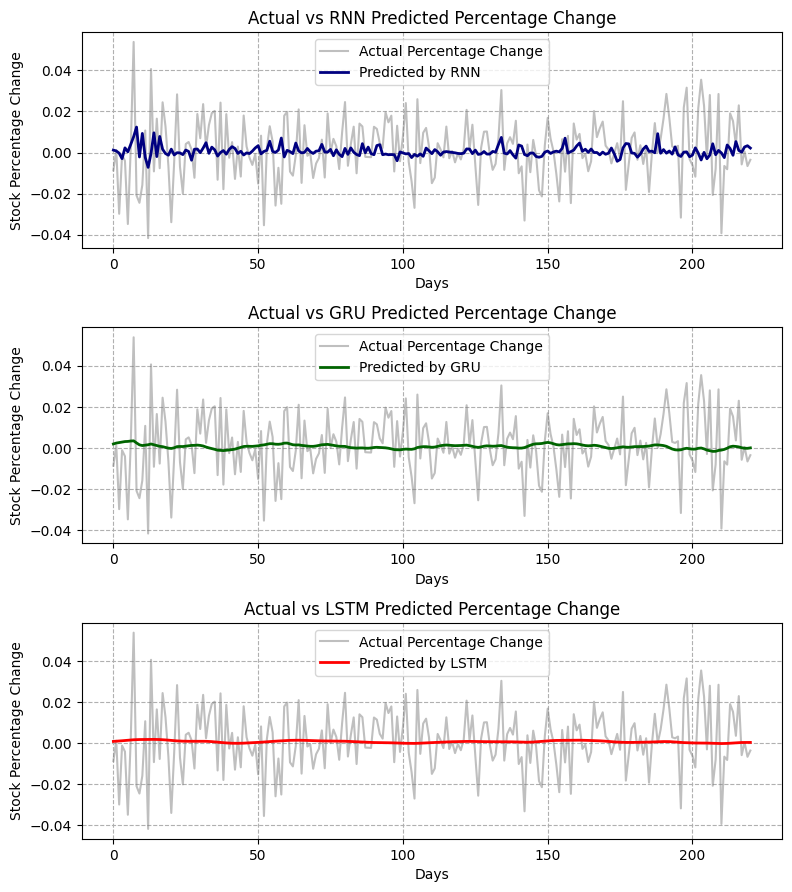

<ipython-input-82-20f777ec946d>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

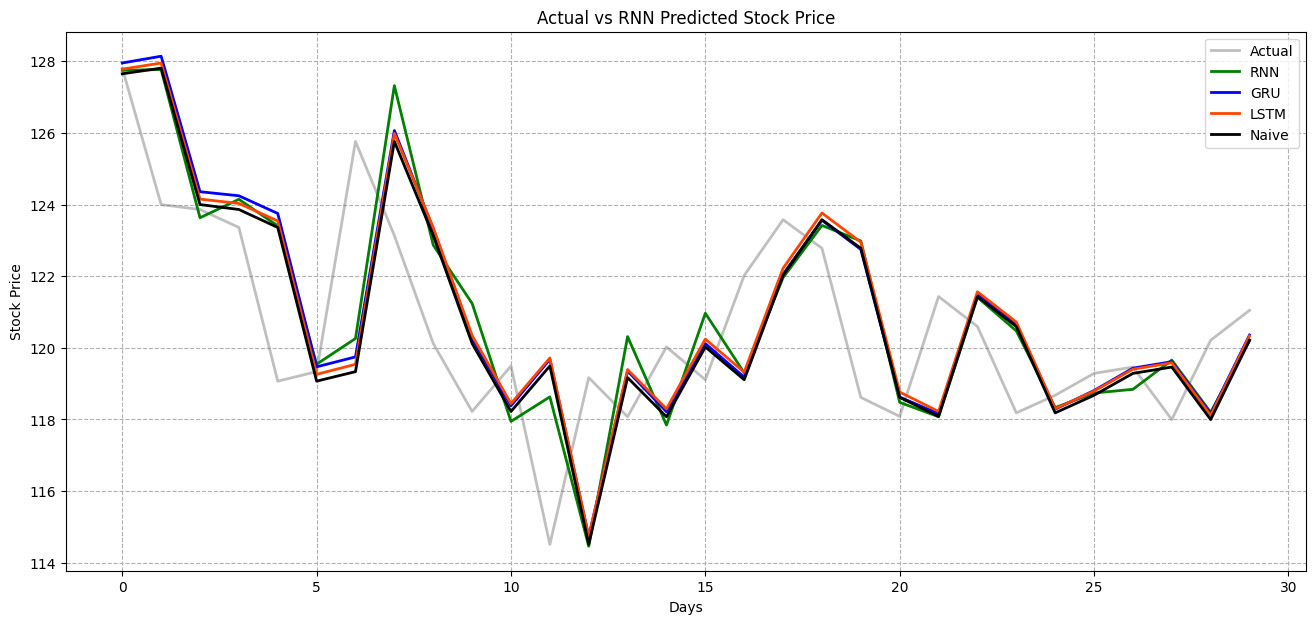

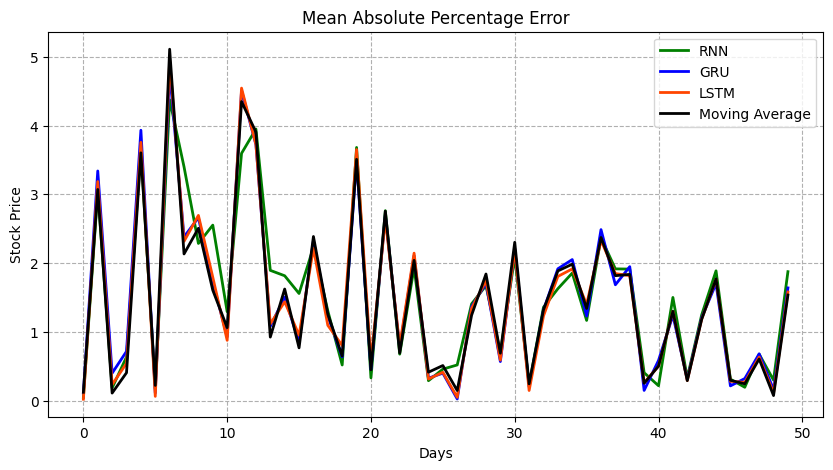

MAPE:
RNN: 1.1883777809903562
GRU: 1.1611423183278866
LSTM: 1.1622778681935344
Moving Average: 1.1943748356830575
Naive: 1.1645696293091747

MAE:
RNN: 1.6587838043608776
GRU: 1.6200028231965433
LSTM: 1.6221741179496
Moving Average: 1.6698080420285002
Naive: 1.6269201105291193

MSE:
RNN: 4.6406251637386635
GRU: 4.528066375993217
LSTM: 4.522052430348319
Moving Average: 4.694433572096163
Naive: 4.537116505856499



<ipython-input-82-20f777ec946d>:191: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)
<ipython-input-82-20f777ec946d>:209: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 3)


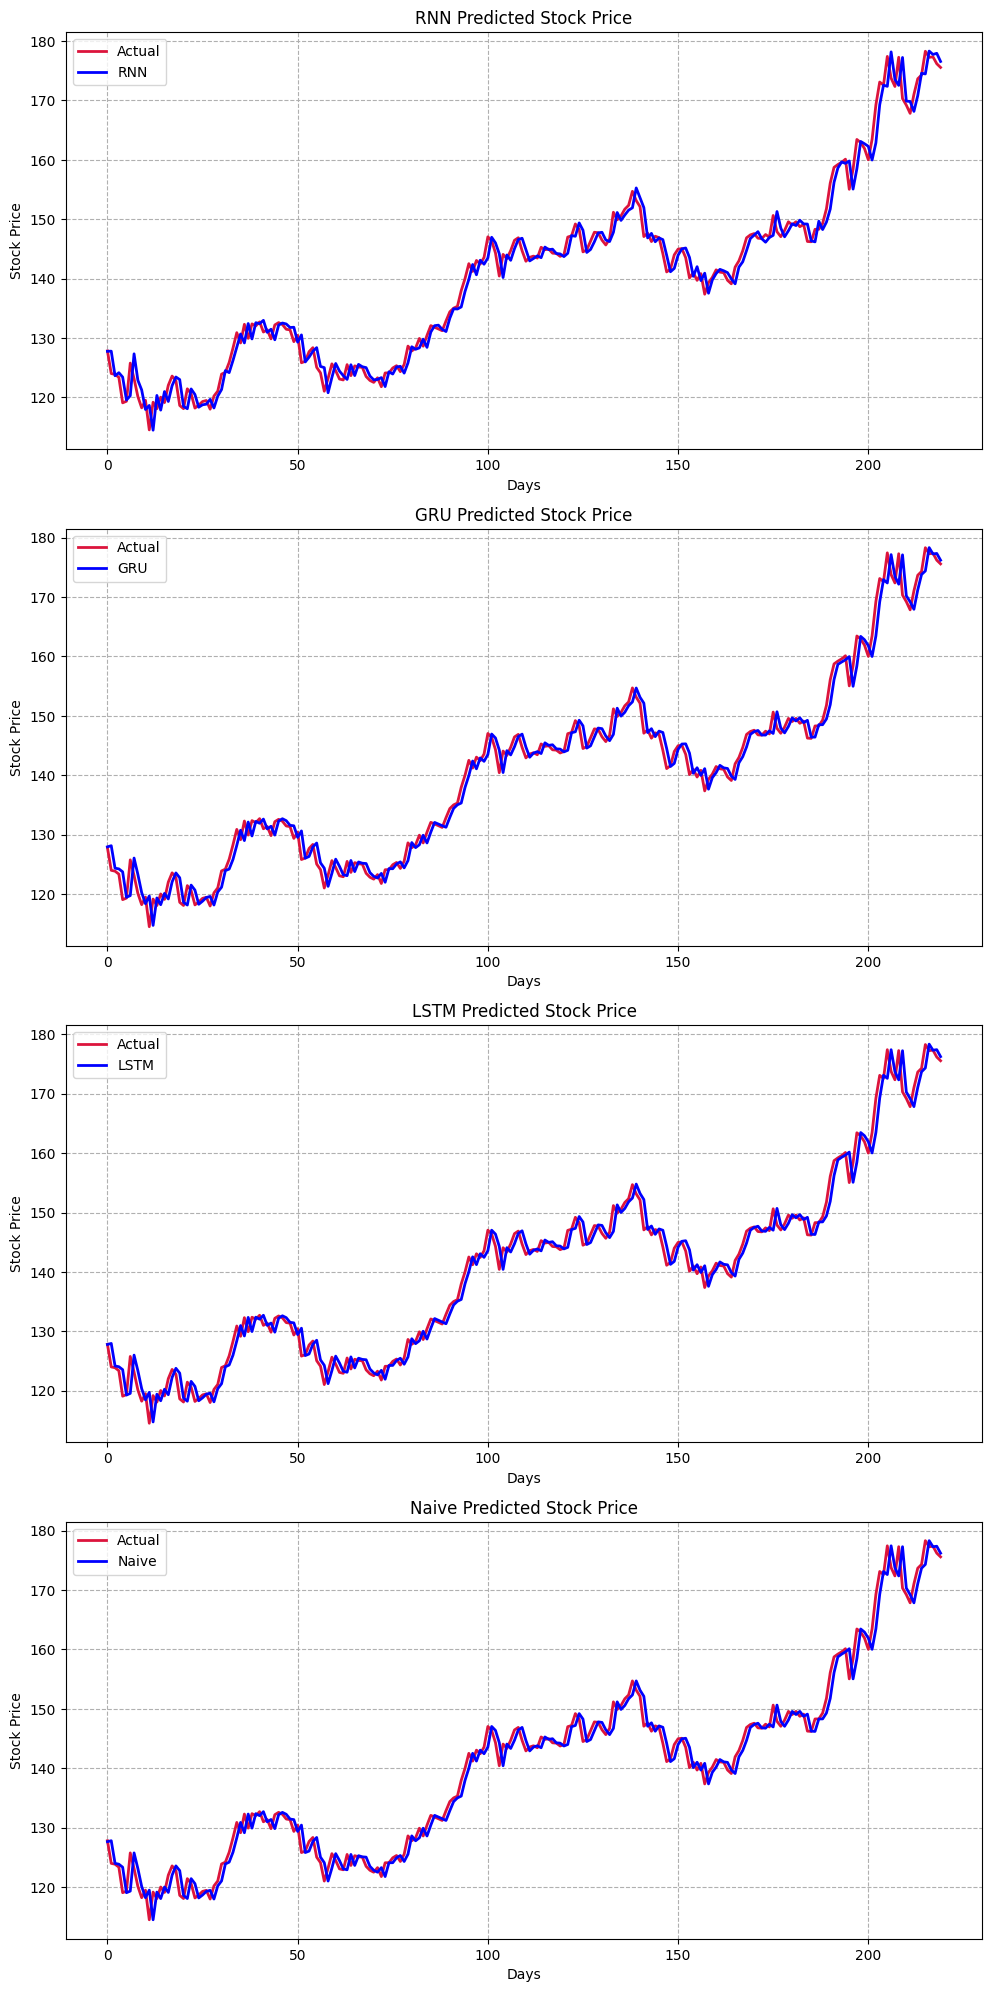

In [ ]:
testing_stock("AAPL")

[*********************100%%**********************]  1 of 1 completed
7/7 [==============================] - 0s 11ms/step
RNN: 0.4796380090497738
GRU: 0.5610859728506787
LSTM: 0.5610859728506787


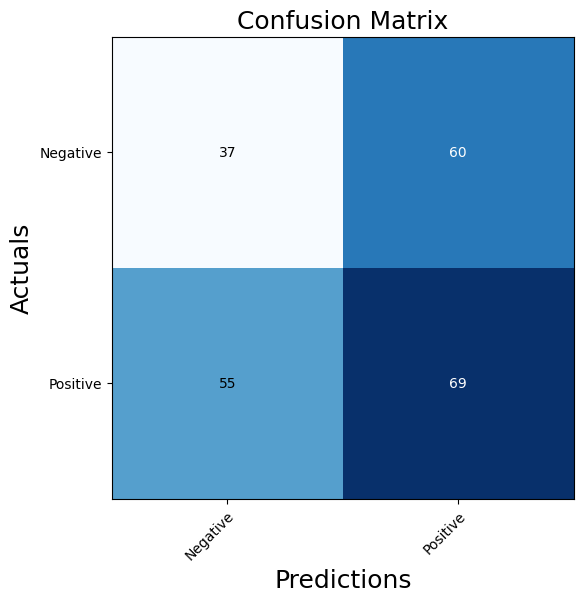

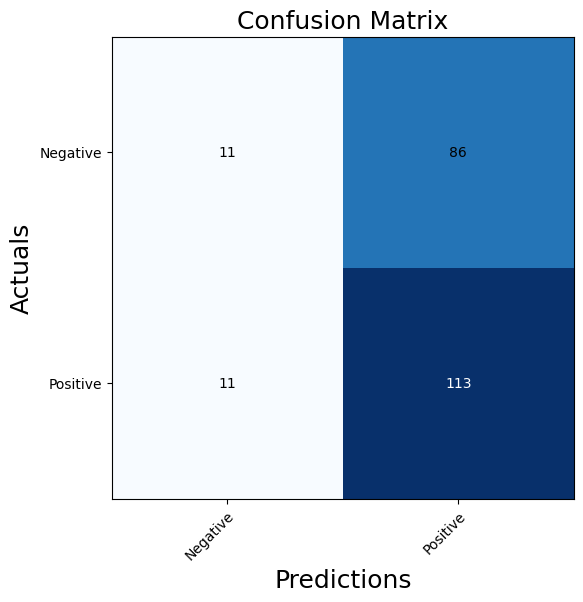

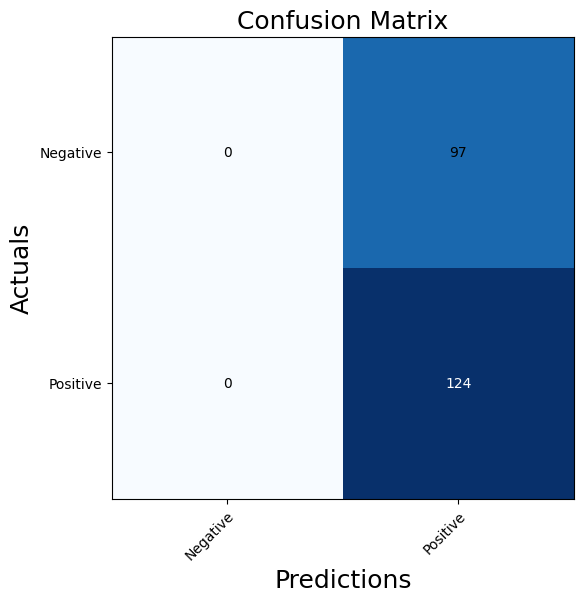

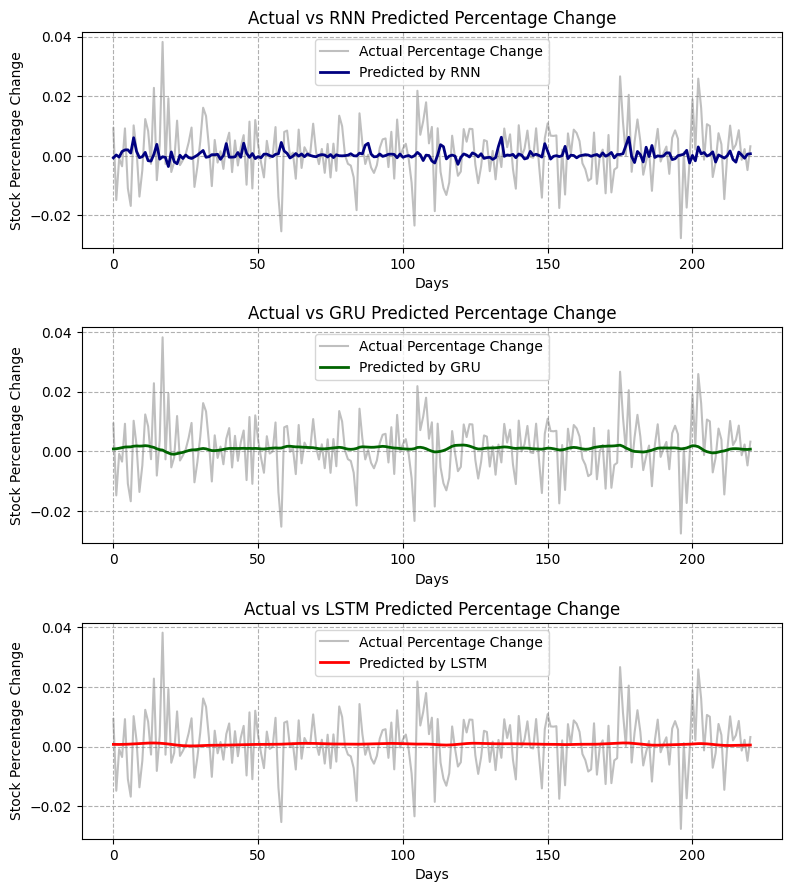

<ipython-input-82-20f777ec946d>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

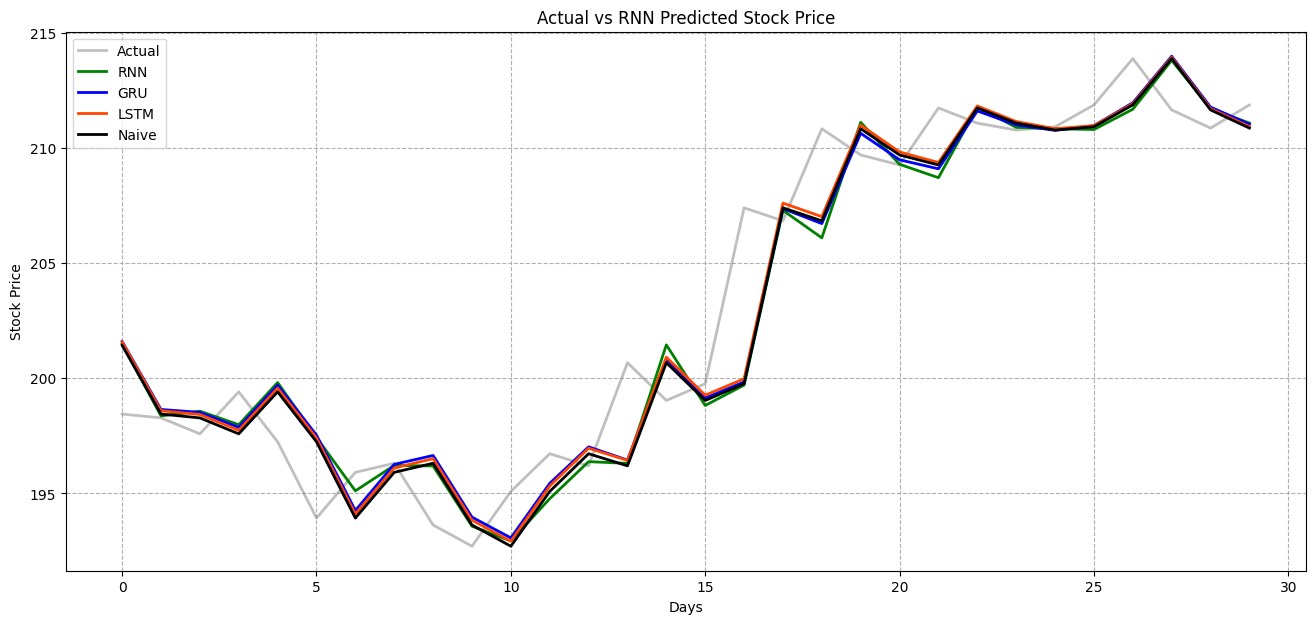

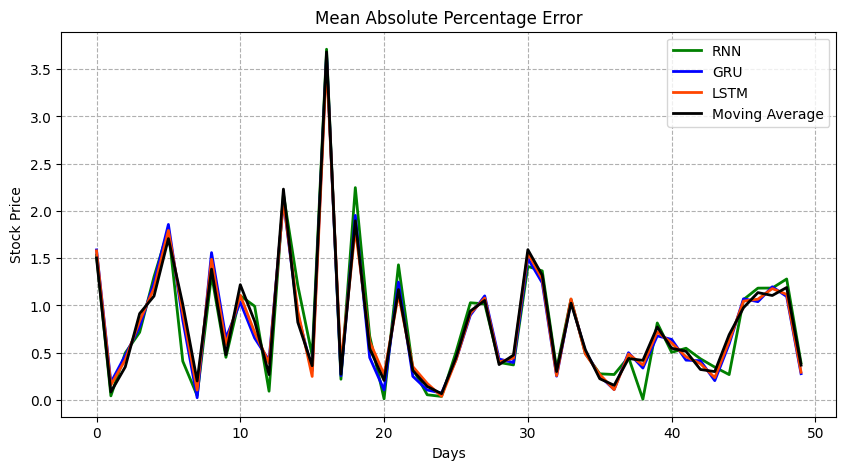

MAPE:
RNN: 0.7295993247844942
GRU: 0.7076957307342235
LSTM: 0.7128354582708569
Moving Average: 0.7193244931824644
Naive: 0.7189096363317551

MAE:
RNN: 1.638819609876603
GRU: 1.5877226541228346
LSTM: 1.5995517149771439
Moving Average: 1.6128680745048134
Naive: 1.6146139665083452

MSE:
RNN: 4.438029102964652
GRU: 4.246196634869265
LSTM: 4.261093549460042
Moving Average: 4.3998380453952
Naive: 4.340704692935105



<ipython-input-82-20f777ec946d>:191: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)
<ipython-input-82-20f777ec946d>:209: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 3)


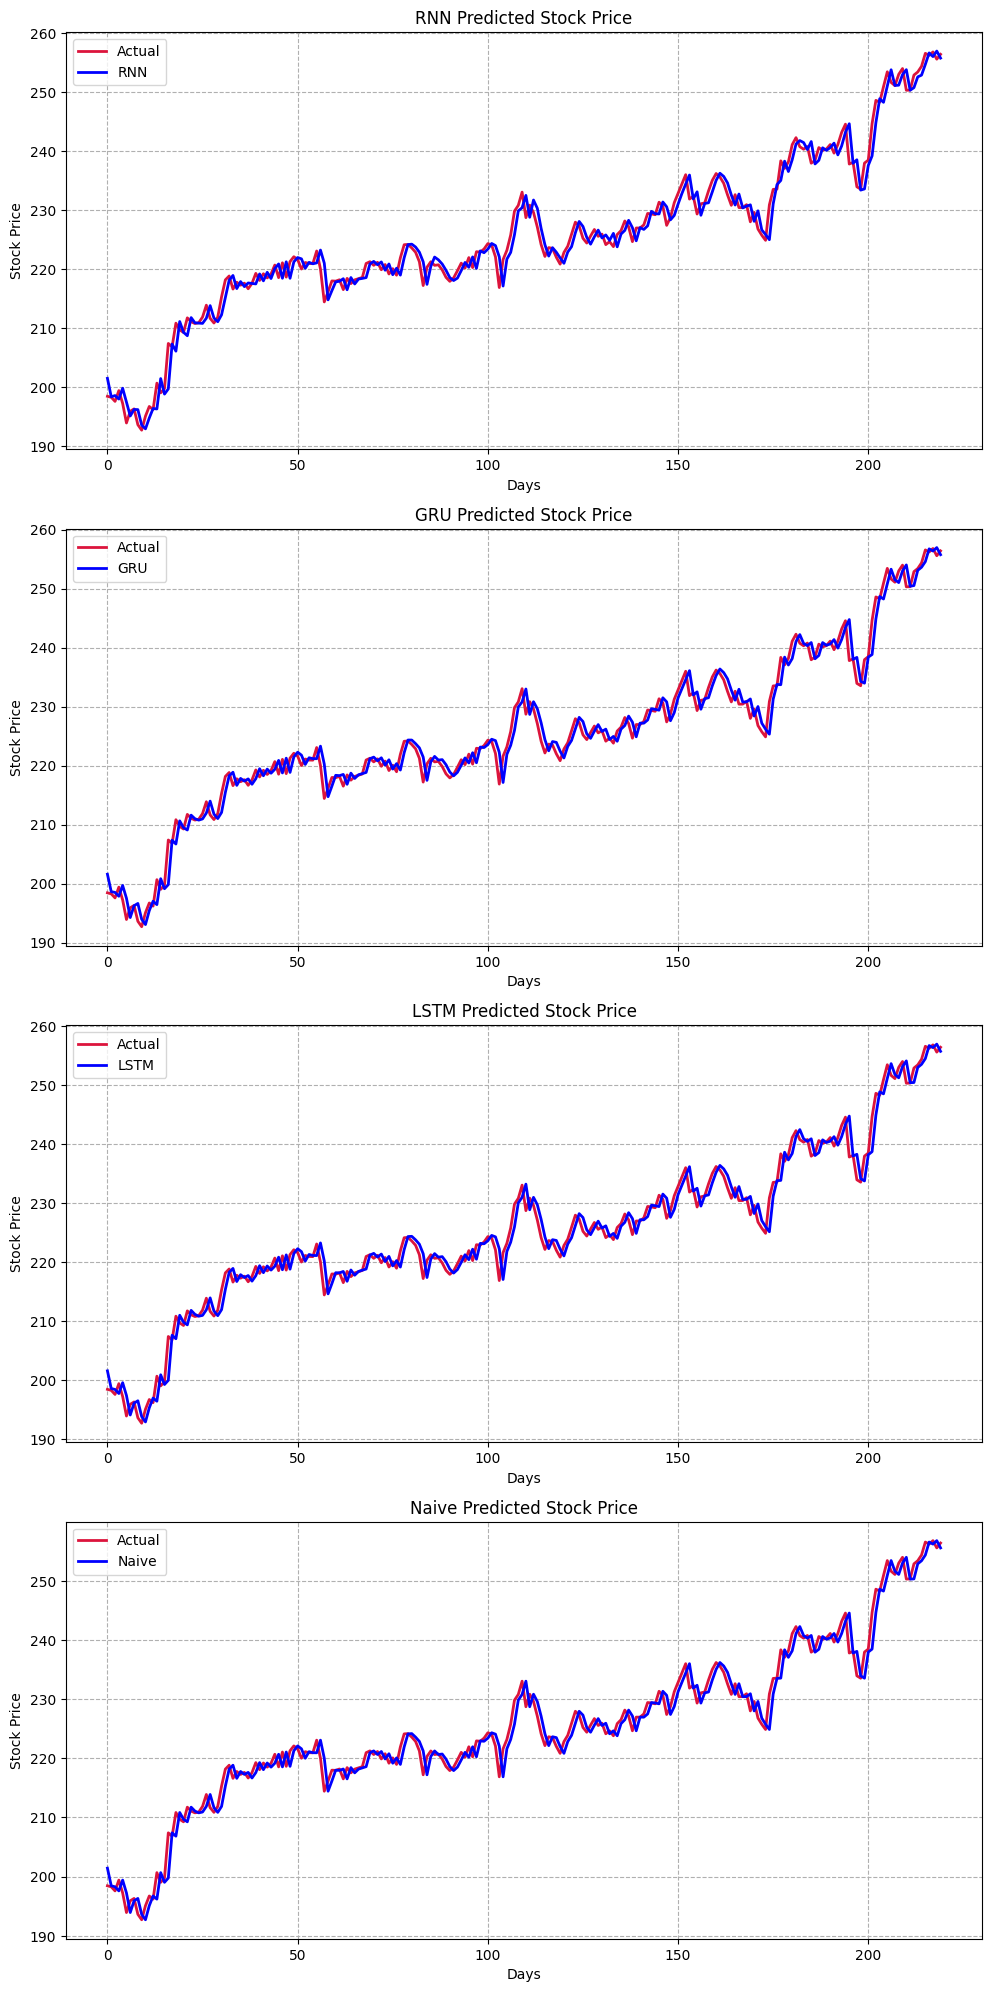

In [ ]:
testing_stock("MCD")

[*********************100%%**********************]  1 of 1 completed
7/7 [==============================] - 0s 11ms/step
RNN: 0.5520361990950227
GRU: 0.49321266968325794
LSTM: 0.5248868778280543


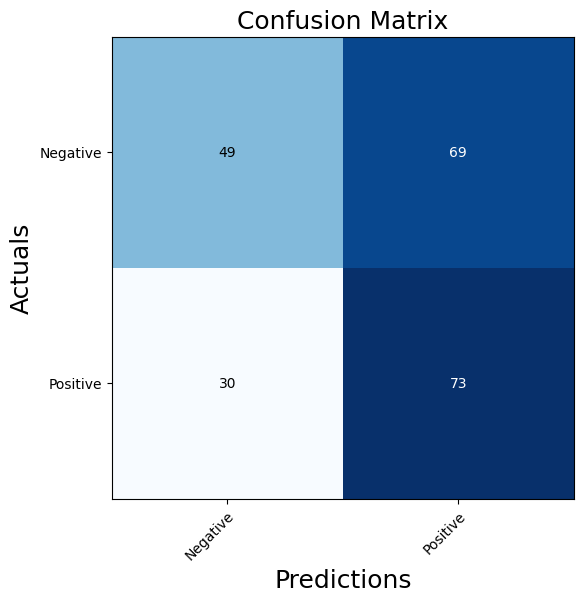

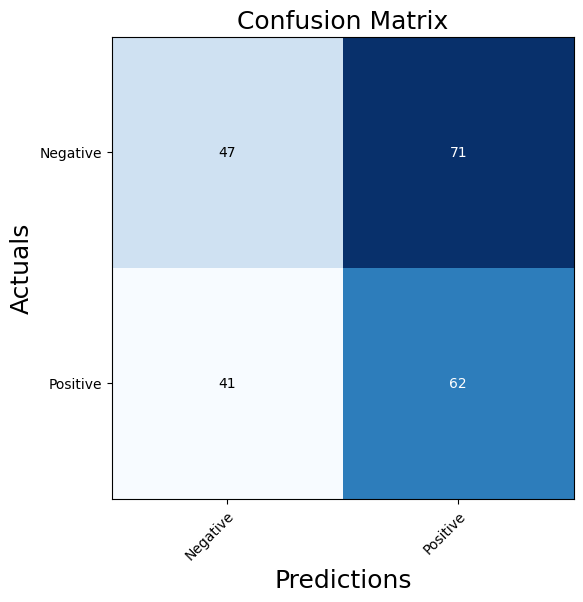

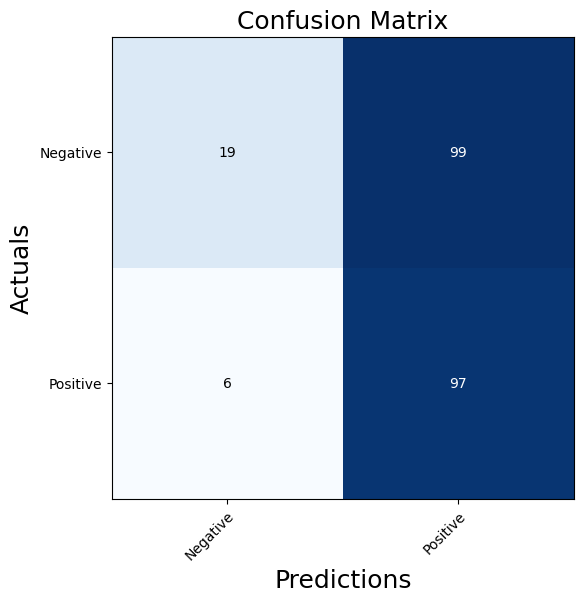

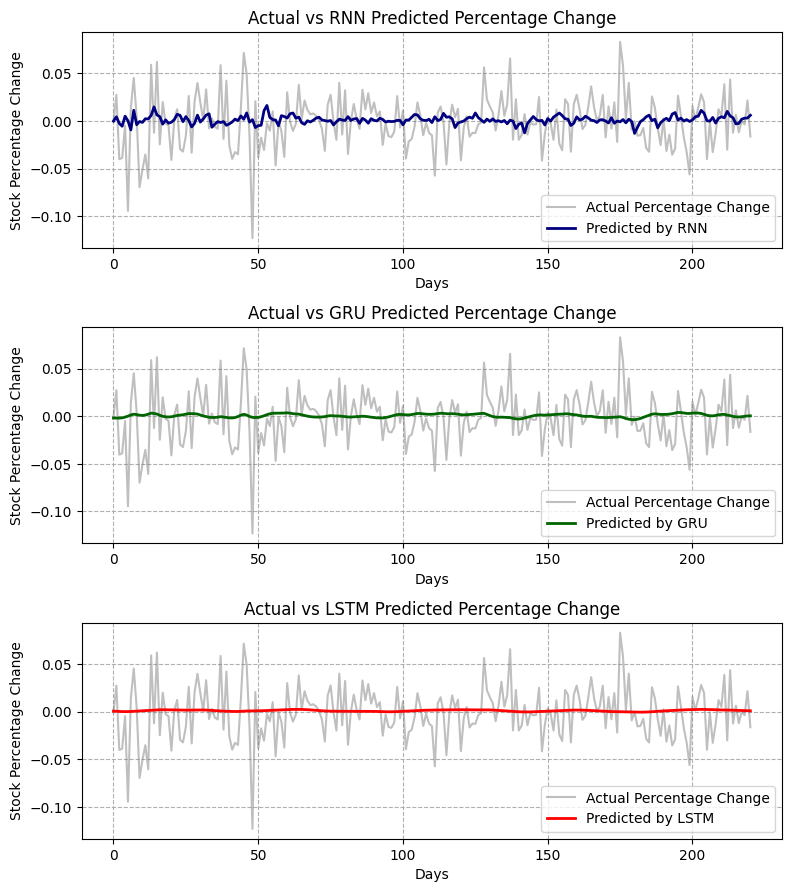

<ipython-input-82-20f777ec946d>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

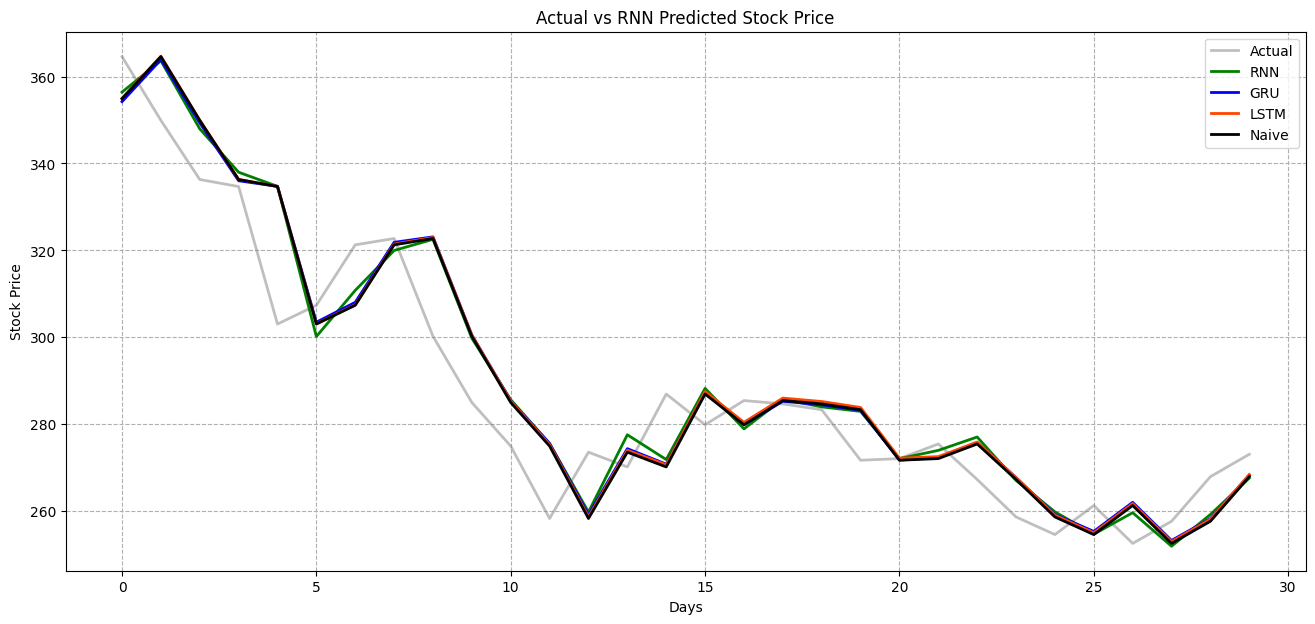

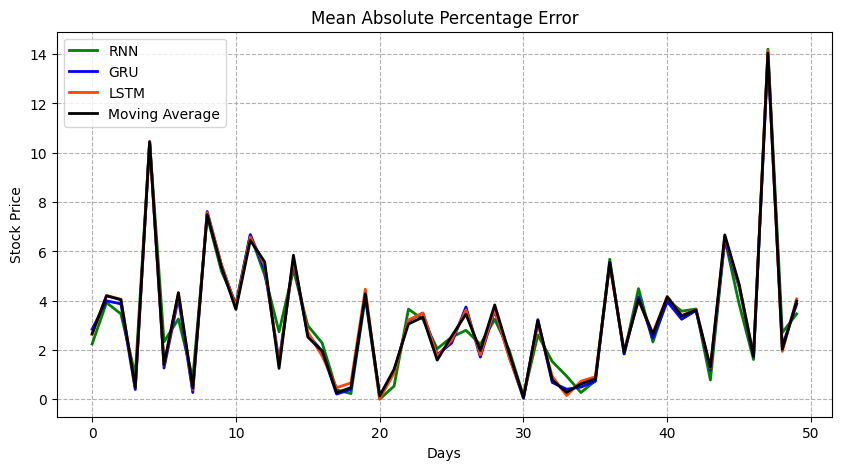

MAPE:
RNN: 2.1711441771298126
GRU: 2.1240104044097365
LSTM: 2.1213138300483583
Moving Average: 2.2163919830200127
Naive: 2.115430667345999

MAE:
RNN: 5.565559261152898
GRU: 5.455656255310574
LSTM: 5.454169784161201
Moving Average: 5.704713034424749
Naive: 5.442590470747514

MSE:
RNN: 56.441945934068215
GRU: 56.04896245453013
LSTM: 56.20555379164277
Moving Average: 59.61278624385561
Naive: 55.87413971988188



<ipython-input-82-20f777ec946d>:191: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)
<ipython-input-82-20f777ec946d>:209: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 3)


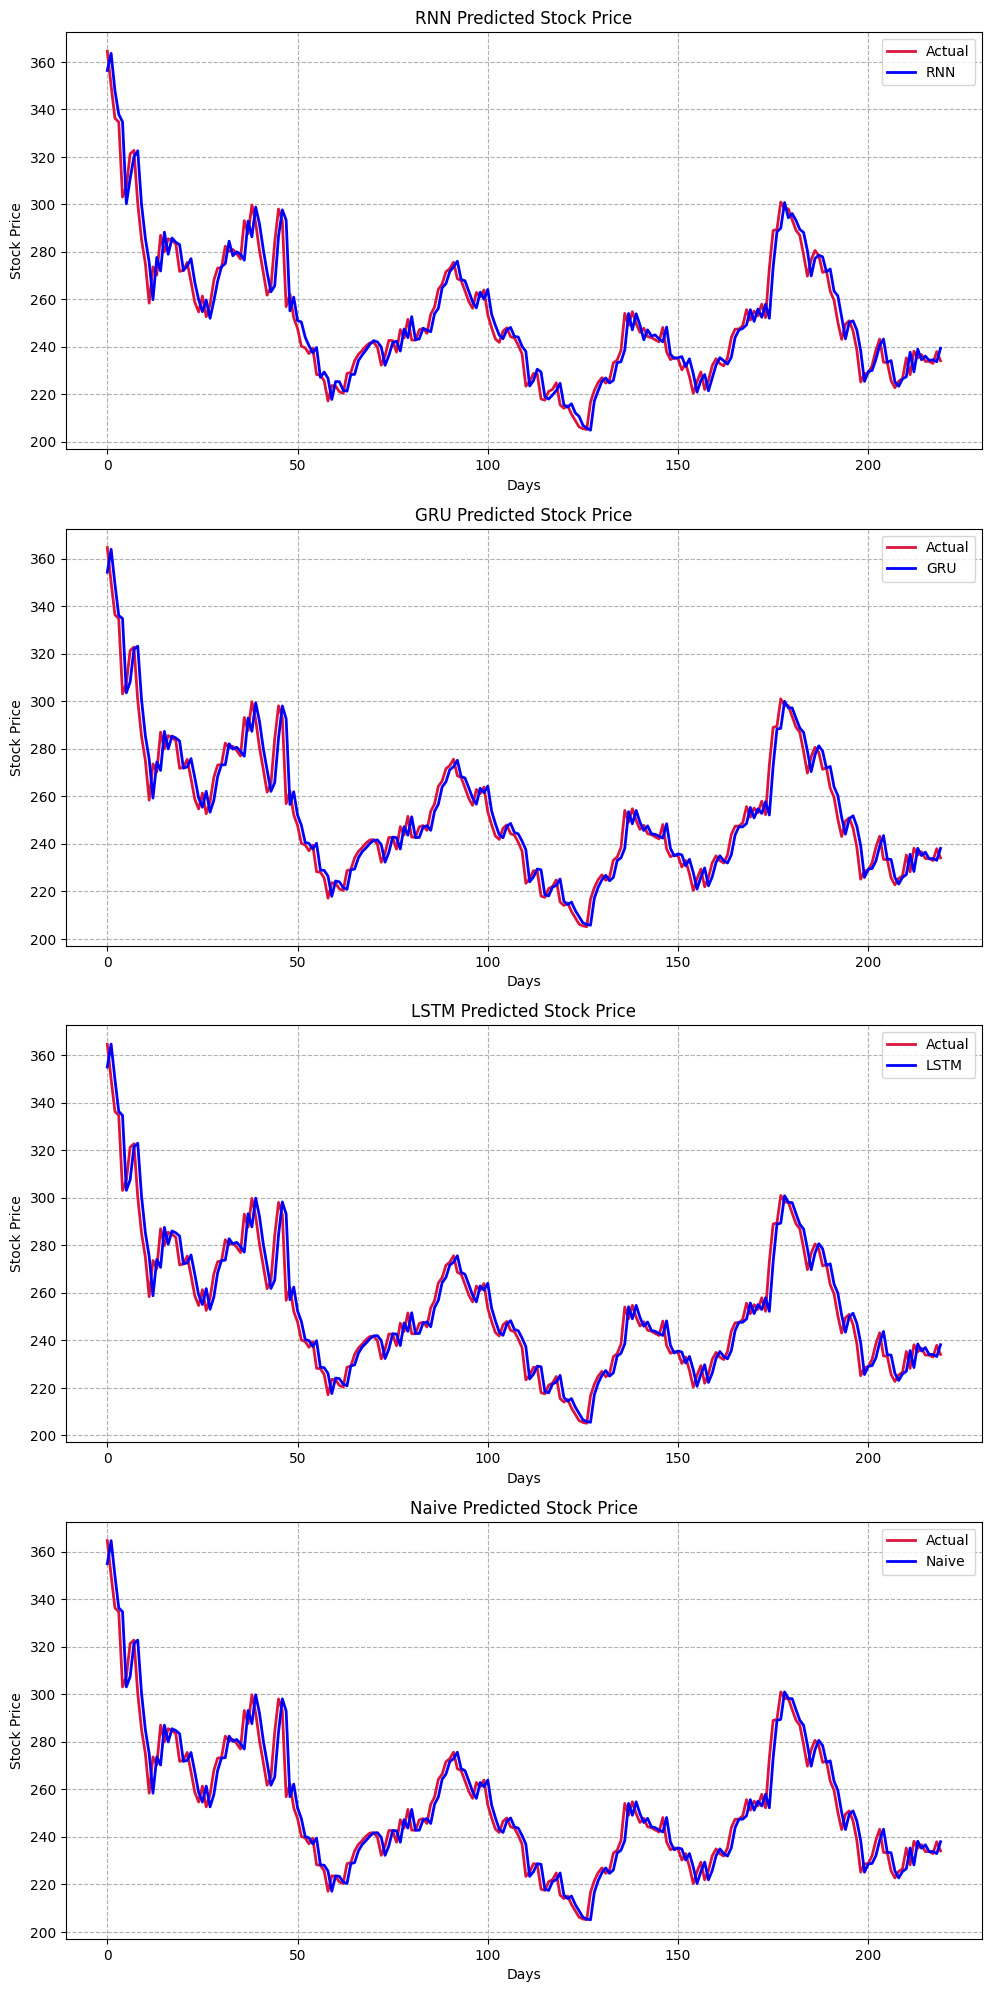

In [ ]:
testing_stock ("SPOT")

[*********************100%%**********************]  1 of 1 completed
7/7 [==============================] - 0s 11ms/step
RNN: 0.5475113122171946
GRU: 0.5158371040723982
LSTM: 0.5656108597285068


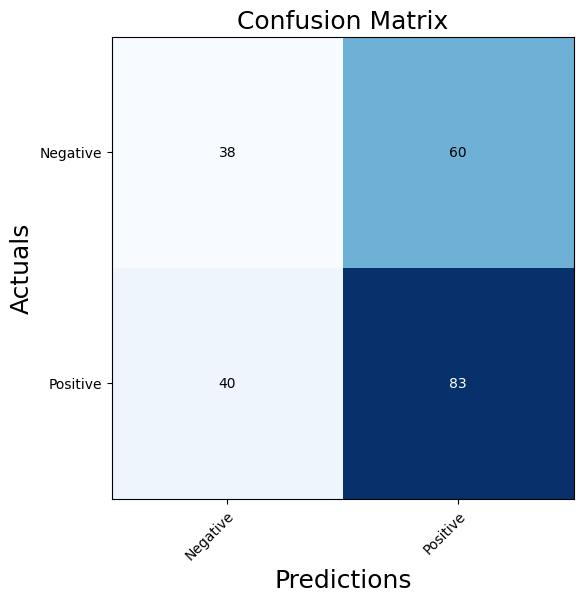

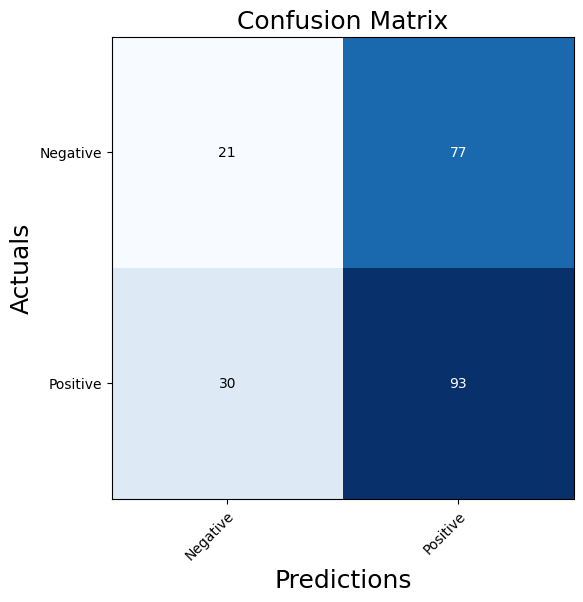

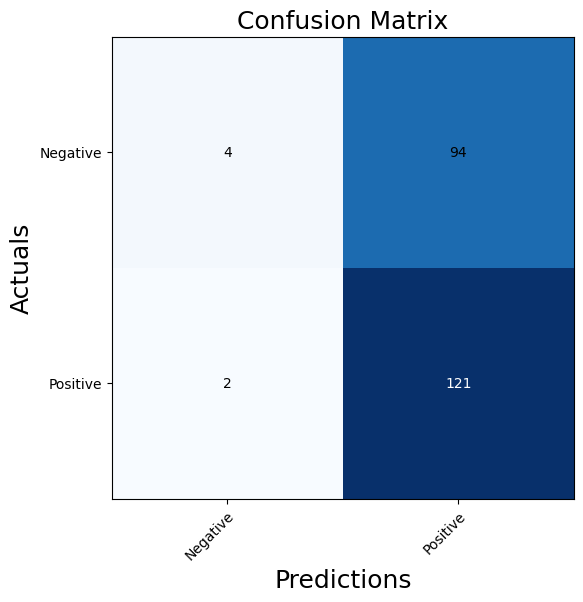

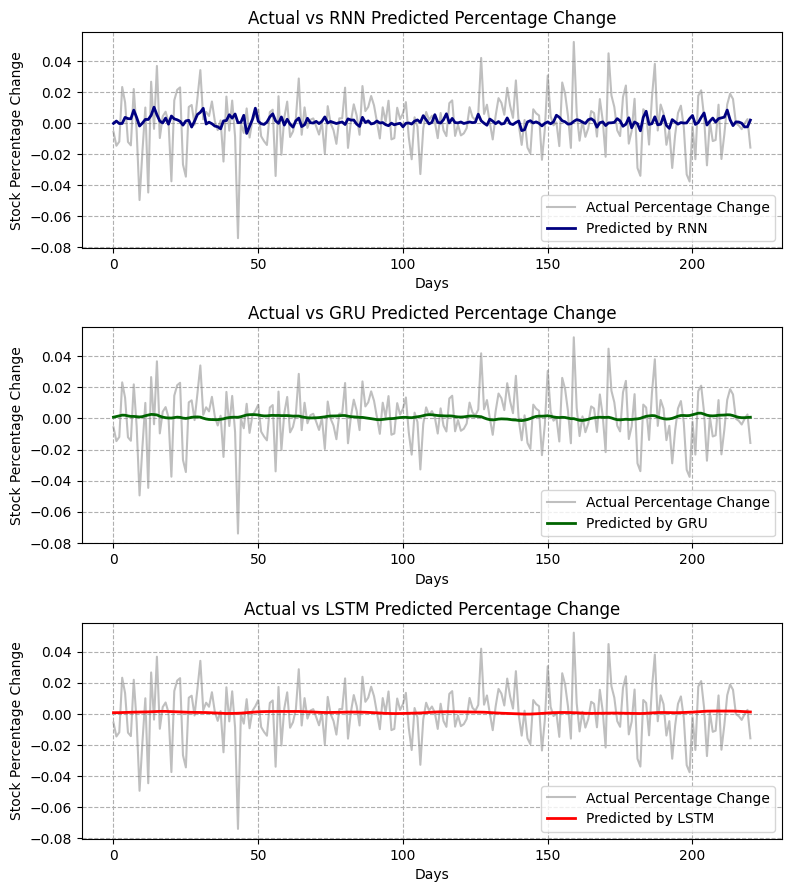

<ipython-input-82-20f777ec946d>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_RNN'] = y_test_pred_RNN_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_pct_GRU'] = y_test_pred_GRU_inv.reshape(-1).tolist()
<ipython-input-82-20f777ec946d>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

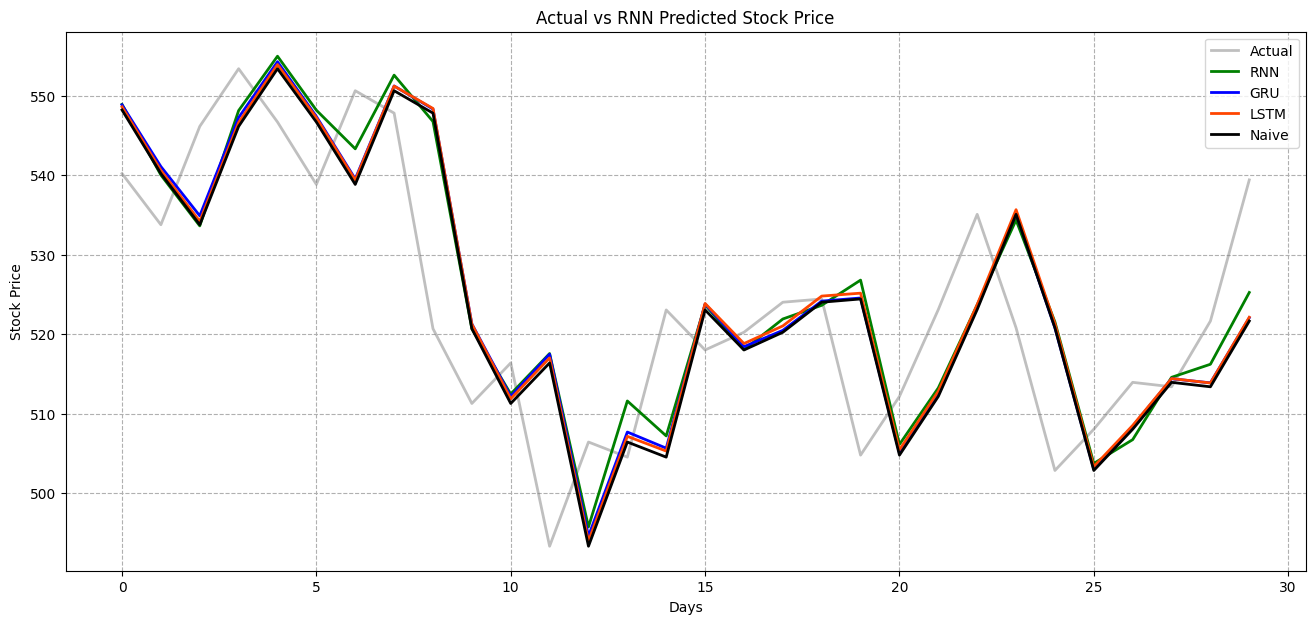

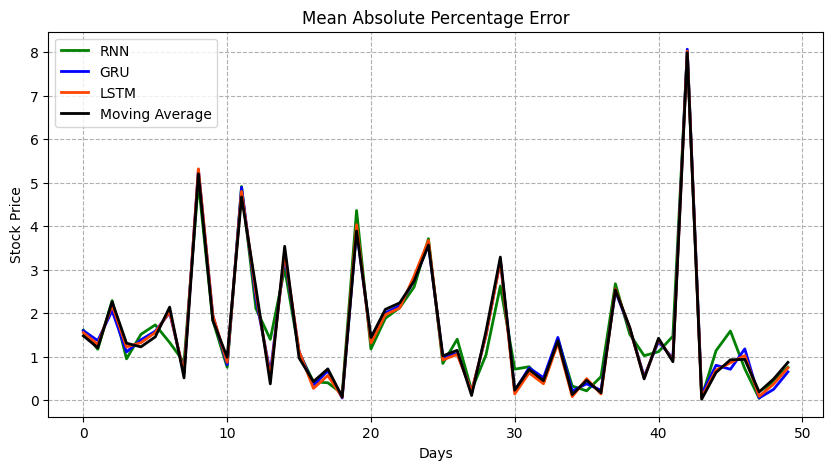

MAPE:
RNN: 1.2338317135182628
GRU: 1.231904608149525
LSTM: 1.2322454629816646
Moving Average: 1.2678897932099753
Naive: 1.237213254991375

MAE:
RNN: 6.957763900383957
GRU: 6.956432966457479
LSTM: 6.963094097645981
Moving Average: 7.1555828151624095
Naive: 6.98981767134233

MSE:
RNN: 88.1066296660264
GRU: 89.88378997867727
LSTM: 89.82971491733227
Moving Average: 94.22333596269551
Naive: 89.73849224443124



<ipython-input-82-20f777ec946d>:191: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)
<ipython-input-82-20f777ec946d>:209: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 3)


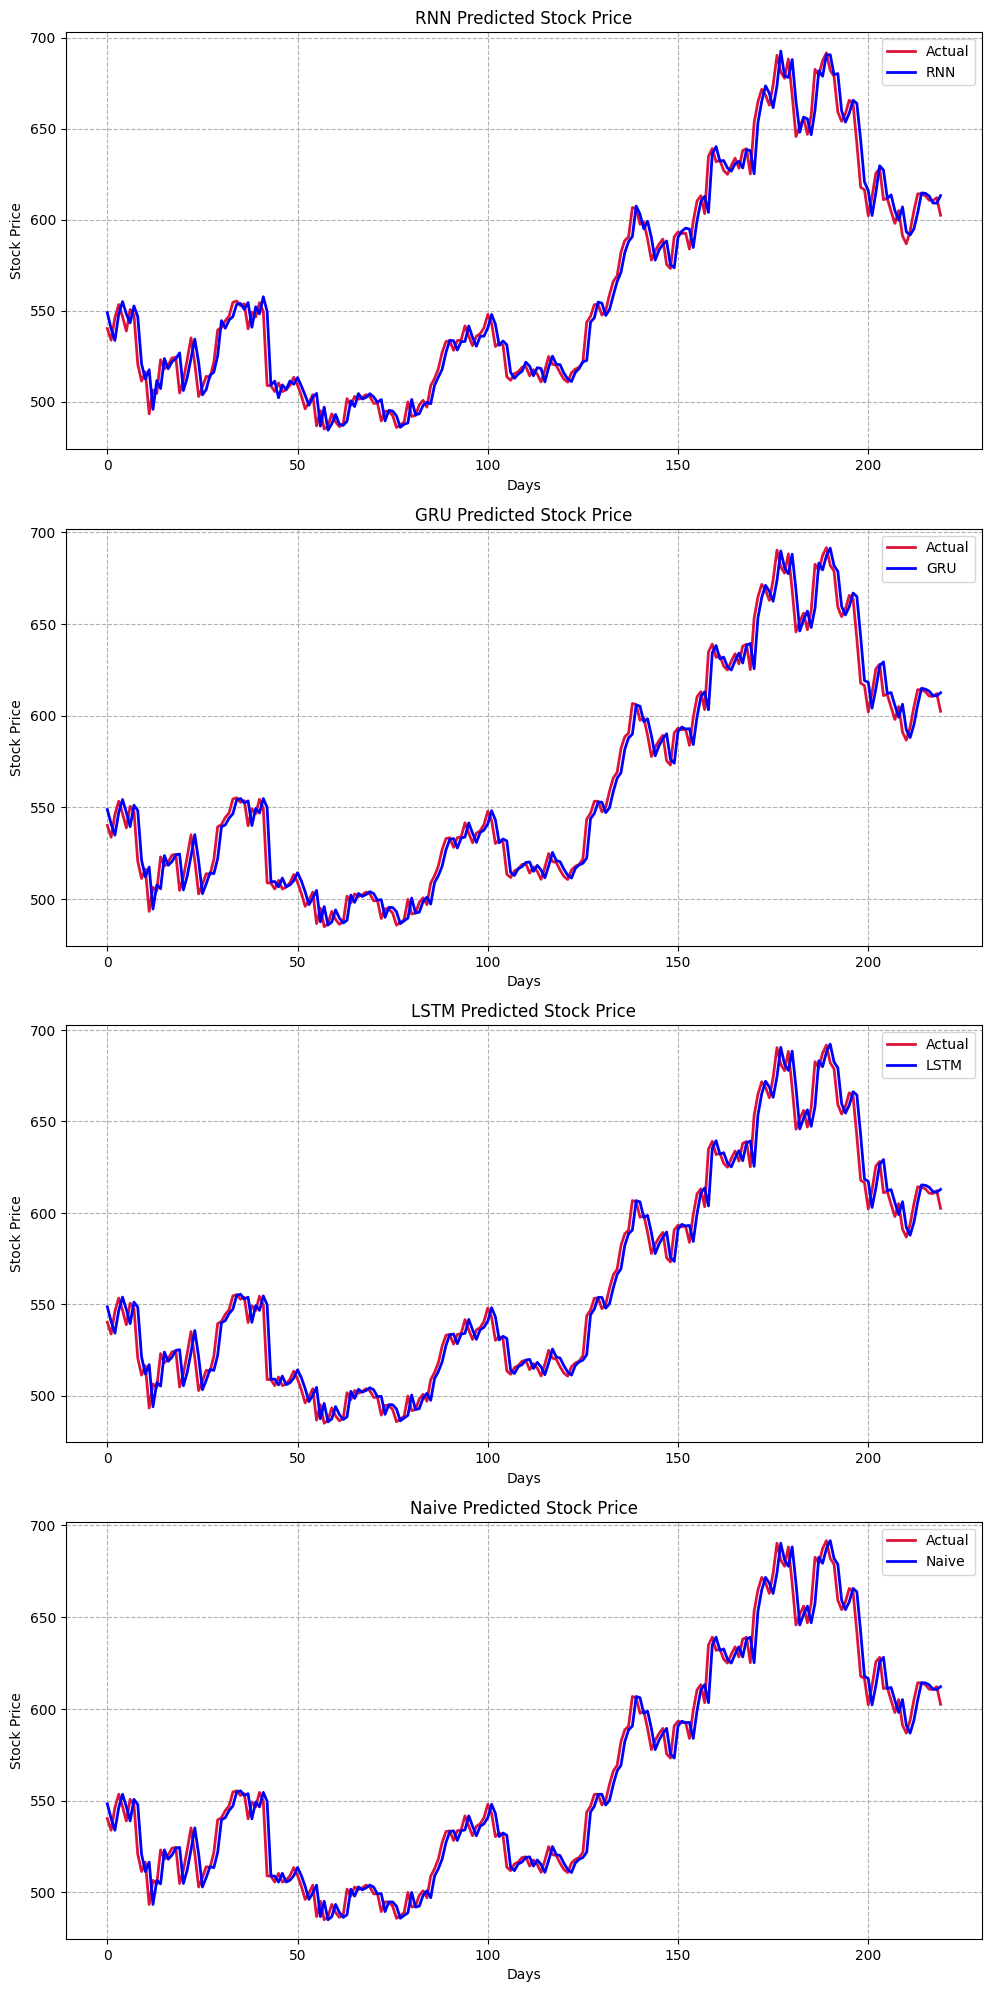

In [ ]:
testing_stock("NFLX")